In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from random import shuffle
import datetime as dt

## 1.
Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!

In [2]:
npickups       = pd.read_csv('npickups_.csv', index_col=0, parse_dates=True)

npickups содержит данные о количестве поездок, в каждый час соответствующей даты (строки) для каждой ячейки (столбцы).
Отфильтруем данные таким образом, чтобы остались только те зоны, в которых среднее количество поездок за май 2016 года
не меньше 5. Таких зон должно быть 102, в соответствии с результатами, полученными на 1ой неделе.

In [3]:
## Создадим датафреймы, вклчающие в себя май и июнь
npickups_june_incl = npickups
npickups_may_incl = npickups.loc[:'2016-05',:]
## Основной датафрейм с которым мы будем работать не будет содержаь данных за май, как следует из задания.
npickups = npickups.loc[:'2016-04', :]

## 2.
Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.


In [4]:
scaler = StandardScaler()
npickups_scl = pd.DataFrame(scaler.fit_transform(npickups),
                            columns = npickups.columns,
                            index = npickups.index)

## 3.
Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

In [5]:
from sklearn.metrics import classification_report, silhouette_score, silhouette_samples
from sklearn.decomposition import RandomizedPCA
from sklearn import manifold
from sklearn.cluster import KMeans

Определим функцию, которая будет производить кластеризацию методом $Kmeans$ и результаты силуэтного анализа: графики коэффициентов силуэта и значения этих коэффициентов. В идеале среднее значение коэффициентов должно быть как можно ближе к $1$, при этом коэффициенты для всех кластеров должны быть распределены равномерно.

In [6]:
def Kmeans_clusterize(data, n_clusters = 6):
    X = data
    range_n_clusters = range(2, n_clusters + 1)

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1, but we'll use from -0.1
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = plt.cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = plt.cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()

In [7]:
## Транспонируем данные, ведь для кластеризации и понижения размерности в качестве признаков у нас выступают 
# временные поездки в данный час.
data = npickups_scl.values.T

('For n_clusters =', 2, 'The average silhouette_score is :', 0.25637393495740179)


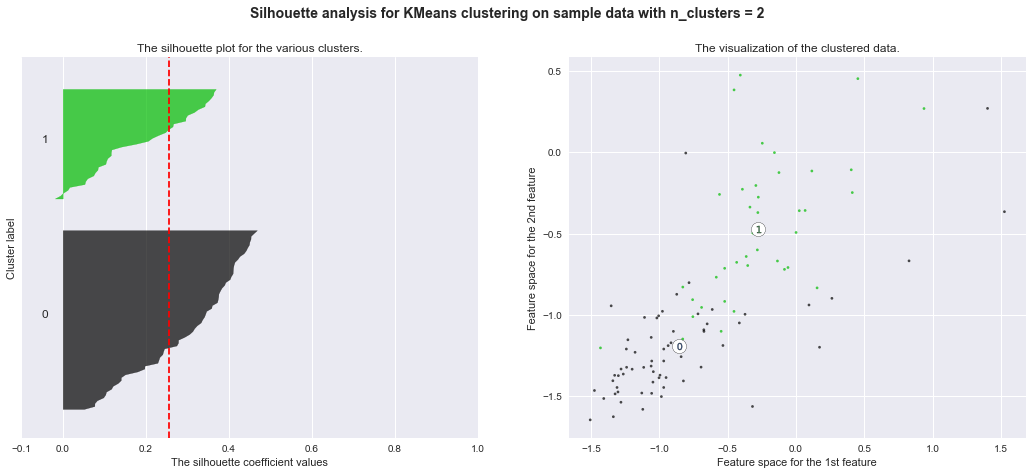

('For n_clusters =', 3, 'The average silhouette_score is :', 0.25482306345791889)


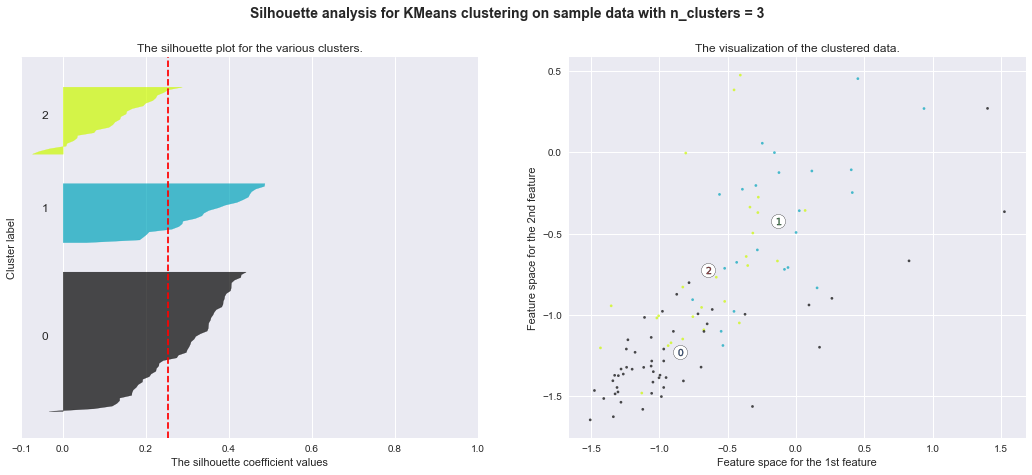

('For n_clusters =', 4, 'The average silhouette_score is :', 0.19936904757565119)


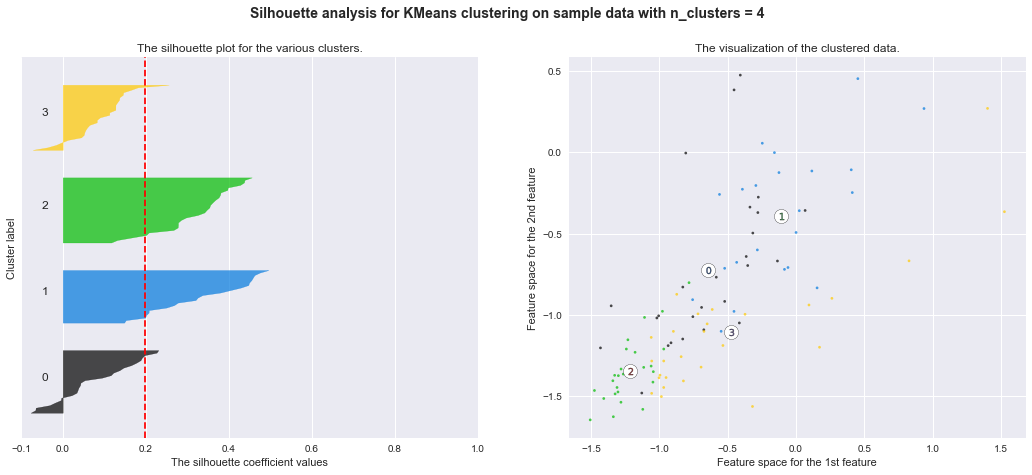

('For n_clusters =', 5, 'The average silhouette_score is :', 0.20359658004633727)


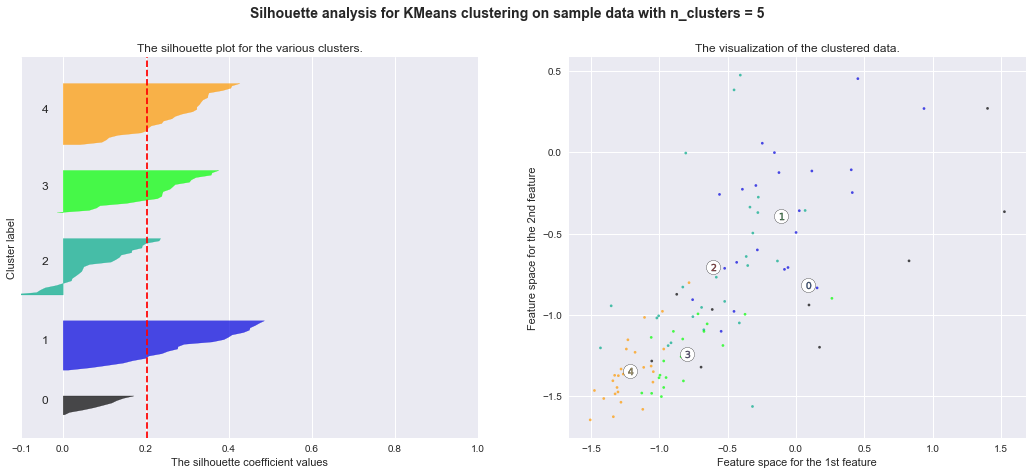

('For n_clusters =', 6, 'The average silhouette_score is :', 0.2058300347028737)


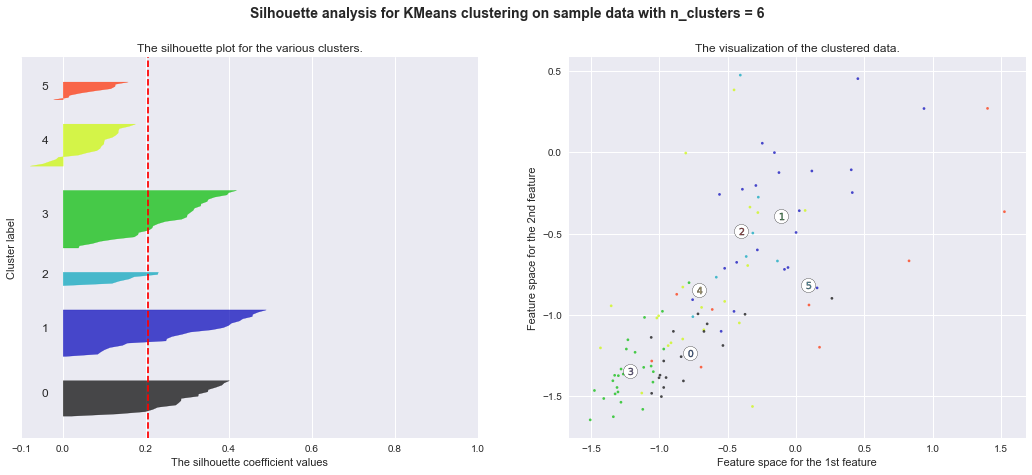

In [8]:
Kmeans_clusterize(data, 6)

Результаты недостаточно хорошие. Во всех случаях значения коэффициента силуэта низкие, а распределение неравномерное.
Попробуем снизить размерность с помощью $Randomized PCA$

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


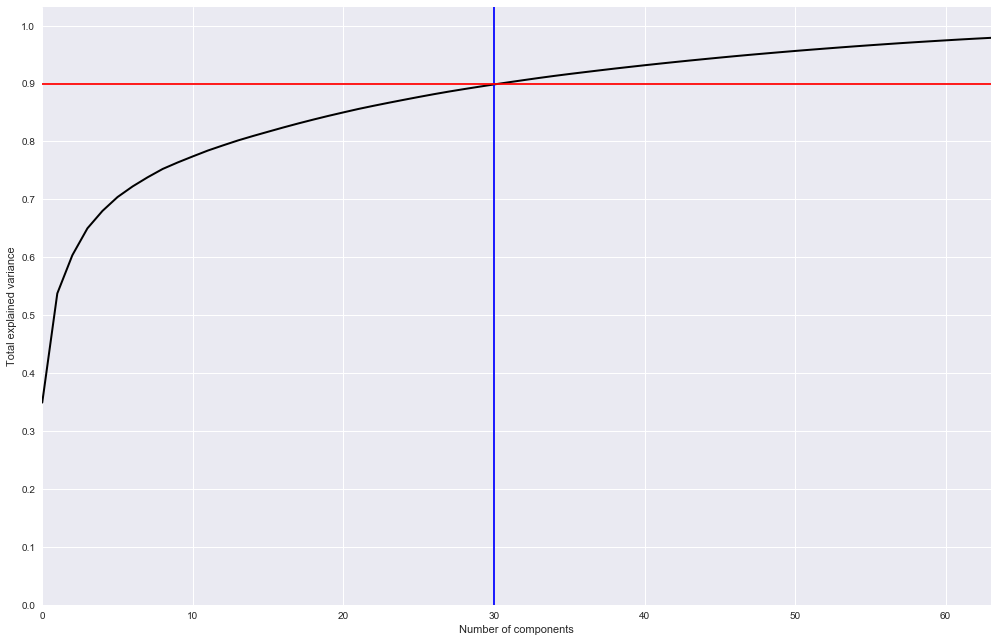

In [9]:
pca = RandomizedPCA().fit(data)
plt.figure(figsize=(17,11))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(30, c='b')
plt.axhline(0.9, c='r')
plt.show();

$30$ компонент объясняют $ 90$% $  $ дисперсии. Учитывая понижение размерности с $4392$ до $30$ это неплохой показатель.

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\utils\deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


('For n_clusters =', 2, 'The average silhouette_score is :', 0.28574439607465568)


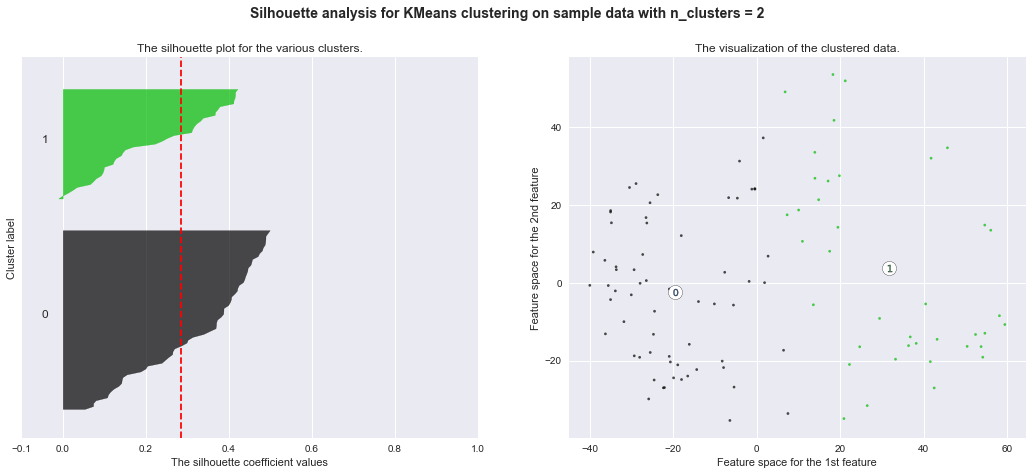

('For n_clusters =', 3, 'The average silhouette_score is :', 0.29185938580719439)


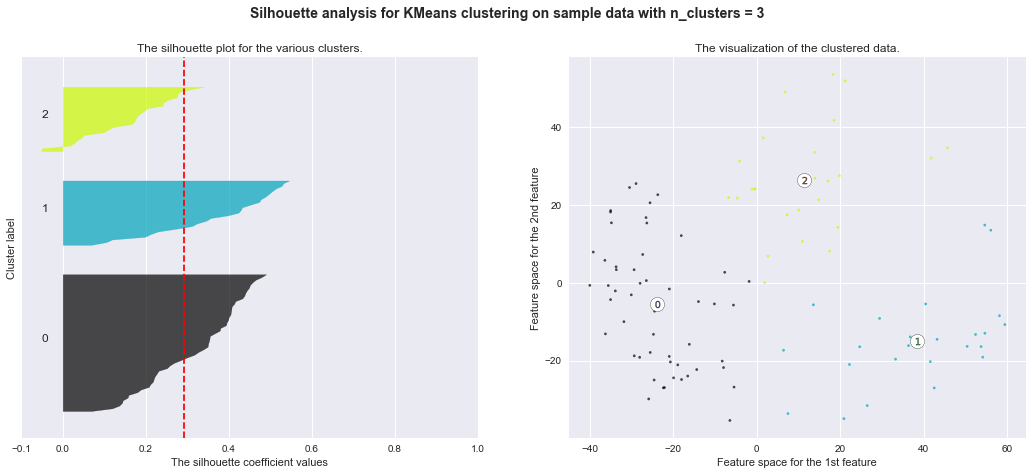

('For n_clusters =', 4, 'The average silhouette_score is :', 0.2442065343315496)


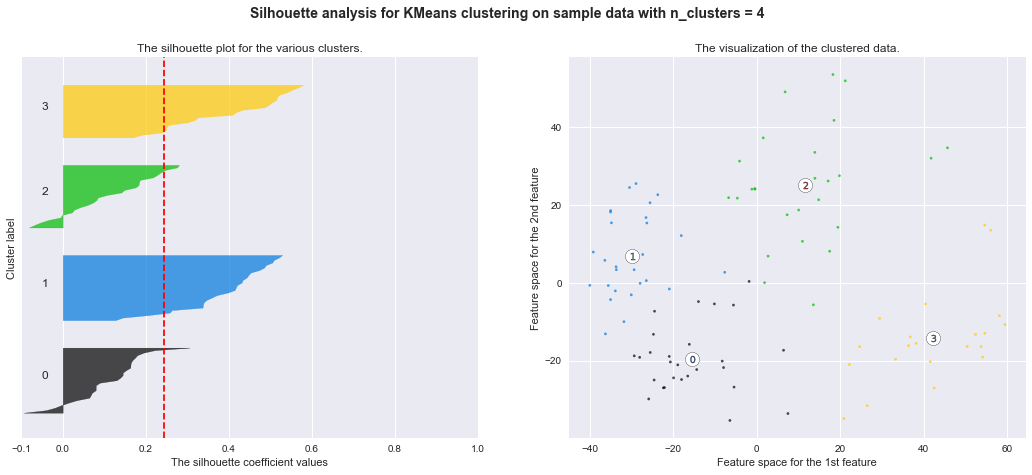

('For n_clusters =', 5, 'The average silhouette_score is :', 0.25007651340192055)


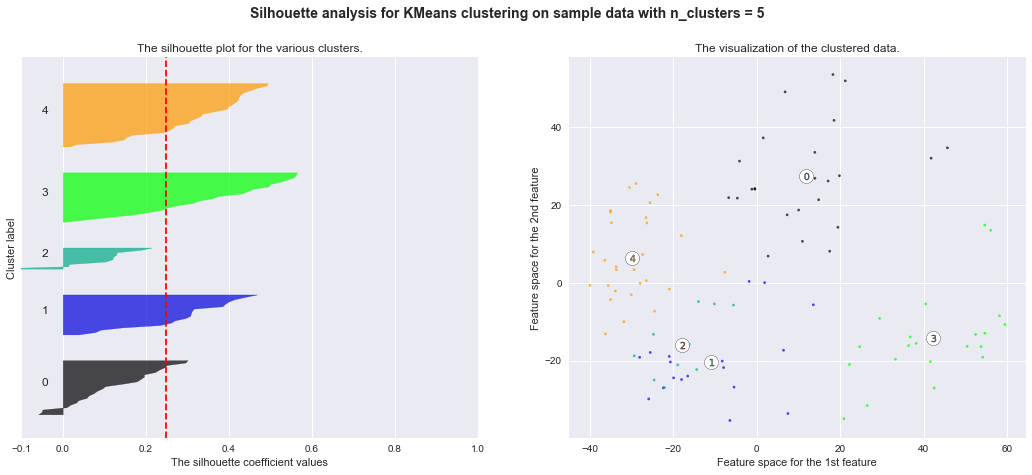

('For n_clusters =', 6, 'The average silhouette_score is :', 0.24431140599086545)


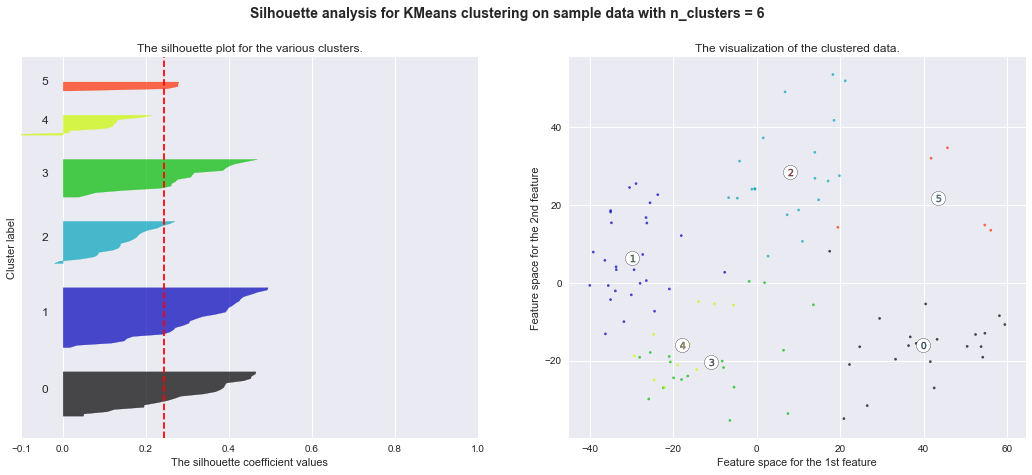

In [10]:
pca = RandomizedPCA(n_components = 32, random_state = 0)
data_pca = pca.fit_transform(data)

Kmeans_clusterize(data_pca, 6)

Уже лучше, но не на много. Попробуем применить $t-SNE$.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.35897239398649267)


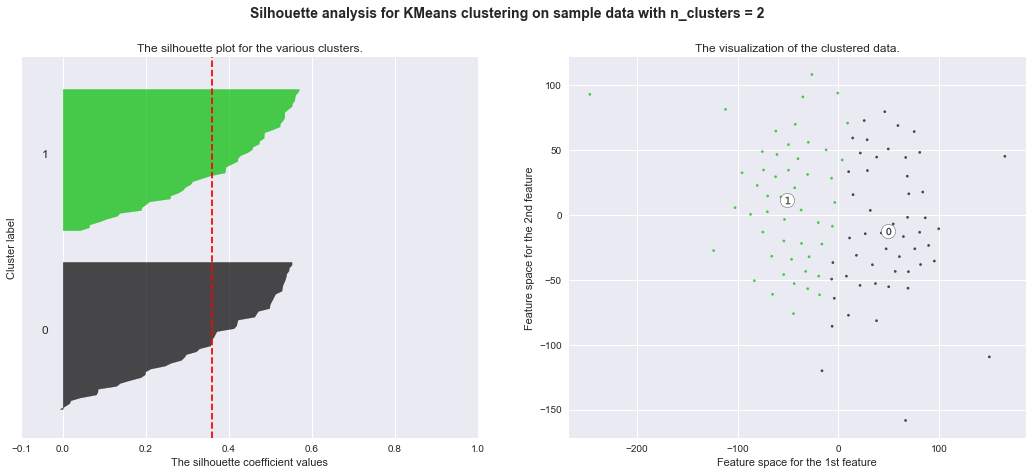

('For n_clusters =', 3, 'The average silhouette_score is :', 0.35904739015553888)


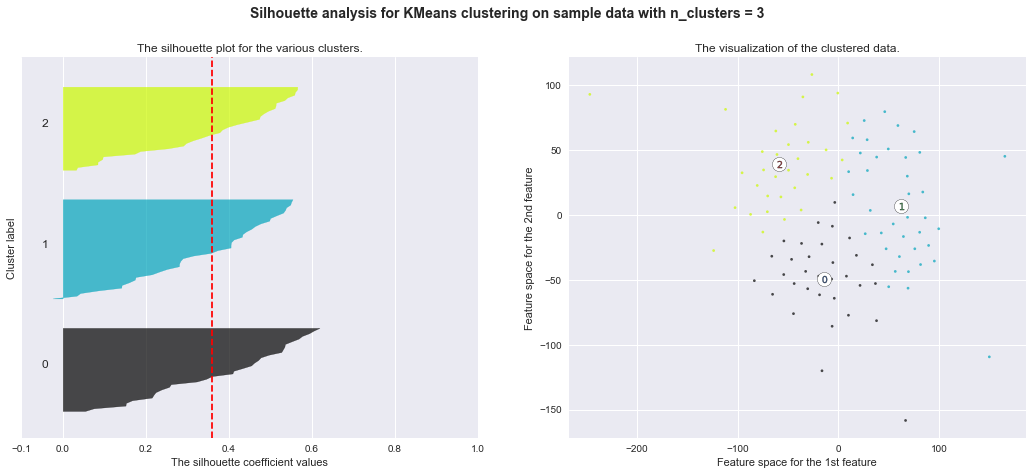

('For n_clusters =', 4, 'The average silhouette_score is :', 0.38166705733479223)


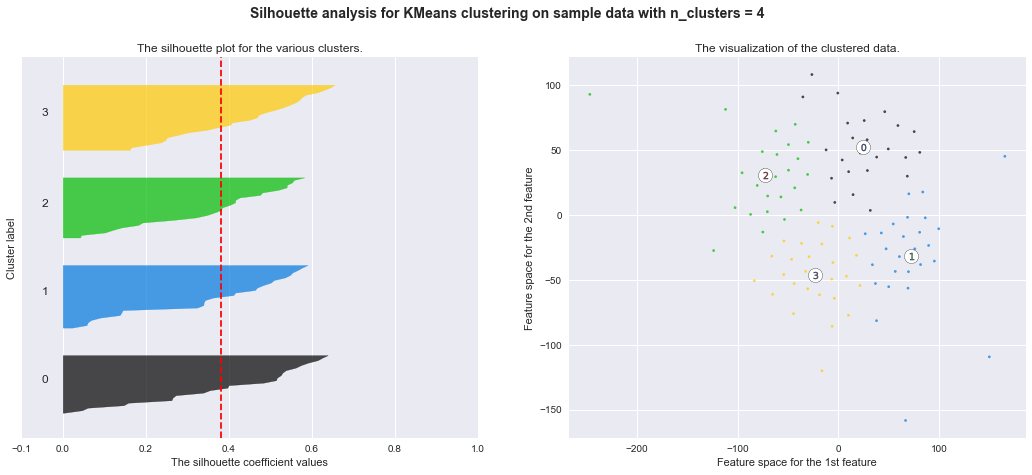

('For n_clusters =', 5, 'The average silhouette_score is :', 0.38598920336991921)


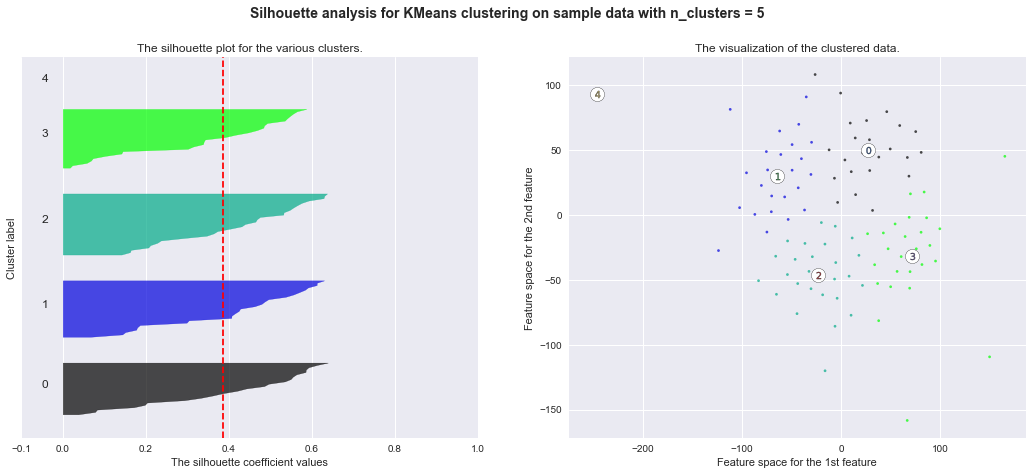

('For n_clusters =', 6, 'The average silhouette_score is :', 0.3387095650775731)


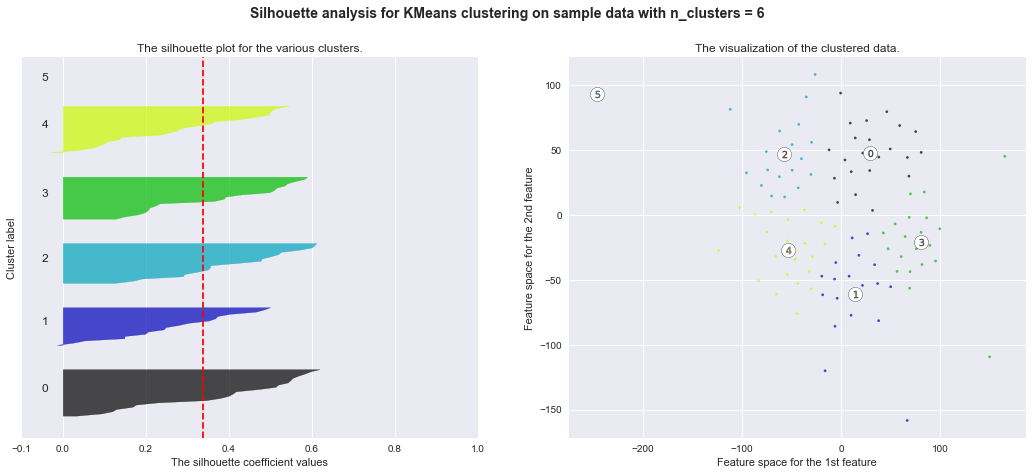

In [11]:
tsne = manifold.TSNE(n_components = 2, init = 'pca', random_state = 0)
data_tsne = tsne.fit_transform(data)
Kmeans_clusterize(data_tsne, 6)

Все еще недостаточно хорошо. Воспользуемся вторым классическим методом (после метода главных компонент) - методом многомерного шкалирования.

('For n_clusters =', 2, 'The average silhouette_score is :', 0.40779261023115337)


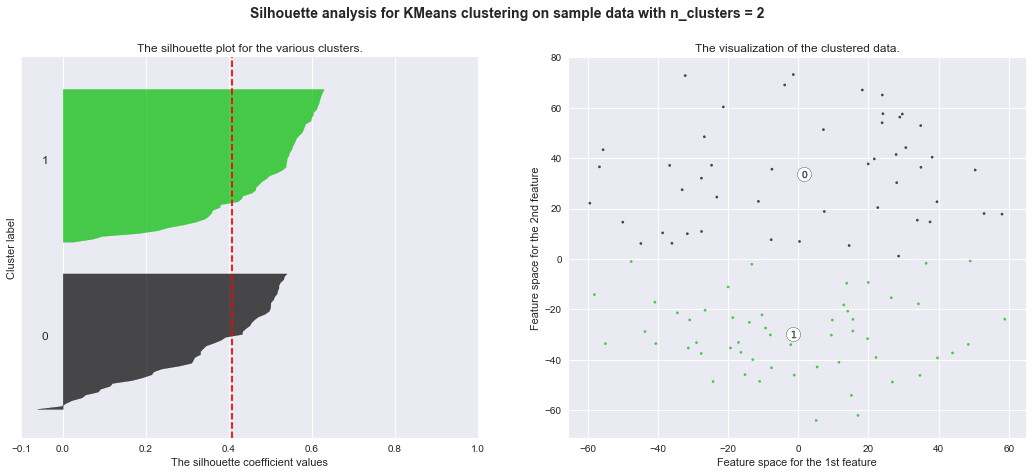

('For n_clusters =', 3, 'The average silhouette_score is :', 0.43672841601498219)


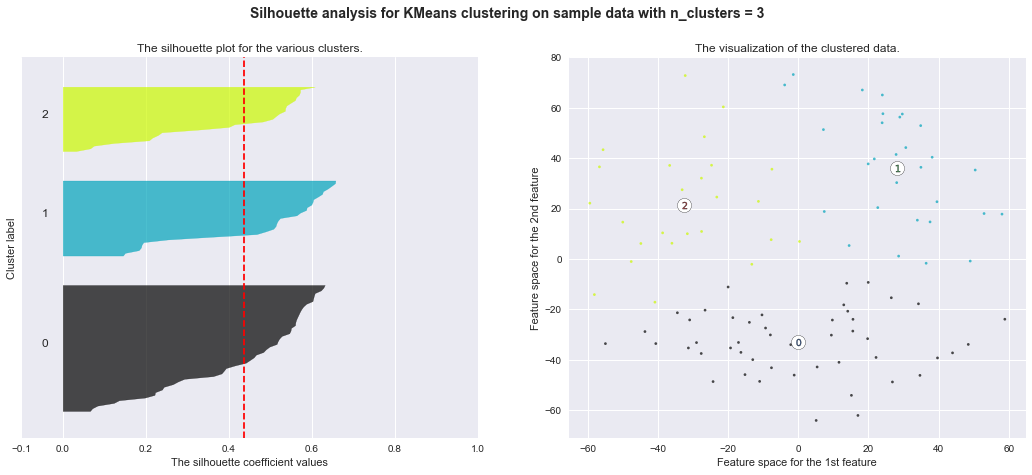

('For n_clusters =', 4, 'The average silhouette_score is :', 0.43289786522208928)


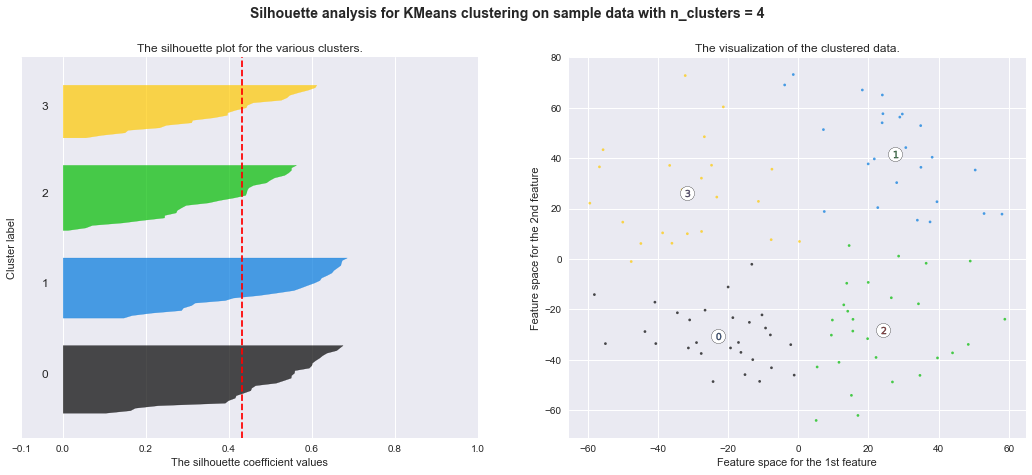

('For n_clusters =', 5, 'The average silhouette_score is :', 0.40812986393553125)


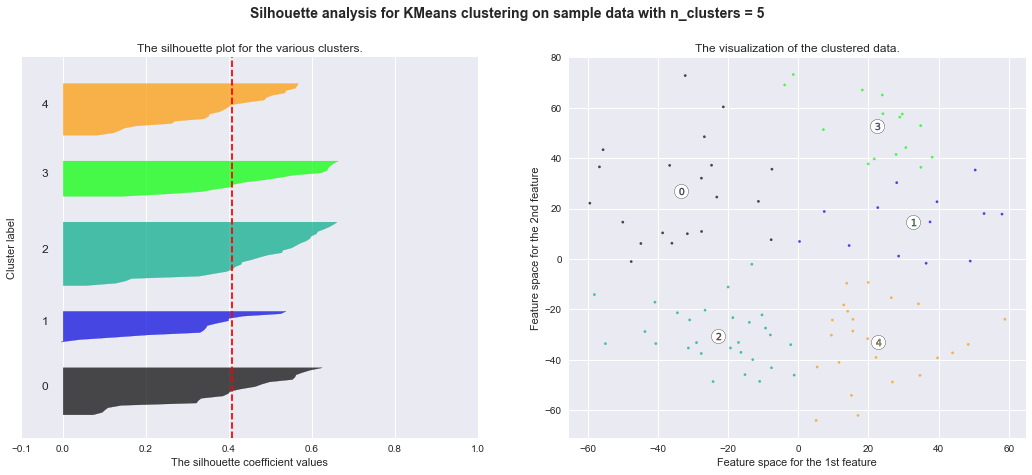

('For n_clusters =', 6, 'The average silhouette_score is :', 0.38405822301160775)


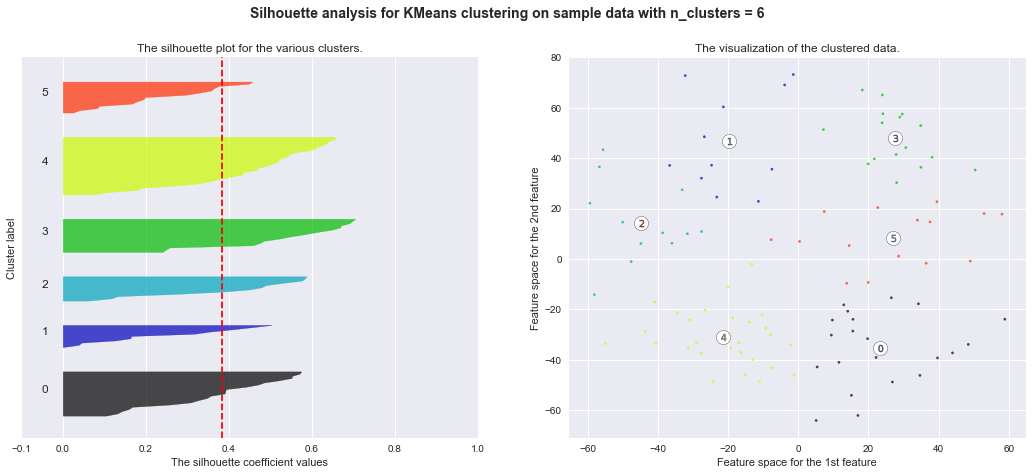

In [12]:
mds = manifold.MDS(n_components = 2, n_init = 3, max_iter = 100, random_state=10)
data_mds = mds.fit_transform(data)
Kmeans_clusterize(data_mds, 6)

Из перечисленных - вариант с многомерным шкалированием и 3 кластерами выглядит наиболее подходящим для дальнешей работы. Остановимся на нем

In [13]:
np.random.seed(10)
n_clusters = 3
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(data_mds)

Теперь выделим 3 региона, наиболее близких к центрам своих кластеров, то есть наиболее характерных представителей кластеров.

In [14]:
from numpy.linalg import norm

In [15]:
## Применим евклидову нору для векторов координат (преобразованных методом МШ), чтобы определить наиболее близкие к центру 
# точки. "Евклидова нора" звучит достаточно оригинально, поэтому я не буду замещать этот случайный неологизм, 
# чтобы и впредь держать внимательного читателя в тонусе.
representers_of_clusters = npickups.columns[[np.argmin([norm(center_crd - region_mds_crd, ord = 2) \
                                                        for region_mds_crd in data_mds]) \
                                            for center_crd in clusterer.cluster_centers_]]
representers_of_clusters

Index([u'1234', u'1228', u'1173'], dtype='object')

In [16]:
regions_clusters = dict(zip(npickups.columns, cluster_labels))

Разделим датафрейм по кластерам

In [17]:
npickups_clstr_0 = npickups.iloc[:, (cluster_labels == 0)]
npickups_clstr_1 = npickups.iloc[:, (cluster_labels == 1)]
npickups_clstr_2 = npickups.iloc[:, (cluster_labels == 2)]

npickups_scl_clstr_0 = npickups_scl.iloc[:, (cluster_labels == 0)]
npickups_scl_clstr_1 = npickups_scl.iloc[:, (cluster_labels == 1)]
npickups_scl_clstr_2 = npickups_scl.iloc[:, (cluster_labels == 2)]

npickups_scl_clstr = [npickups_scl_clstr_0, npickups_scl_clstr_1, npickups_scl_clstr_2]

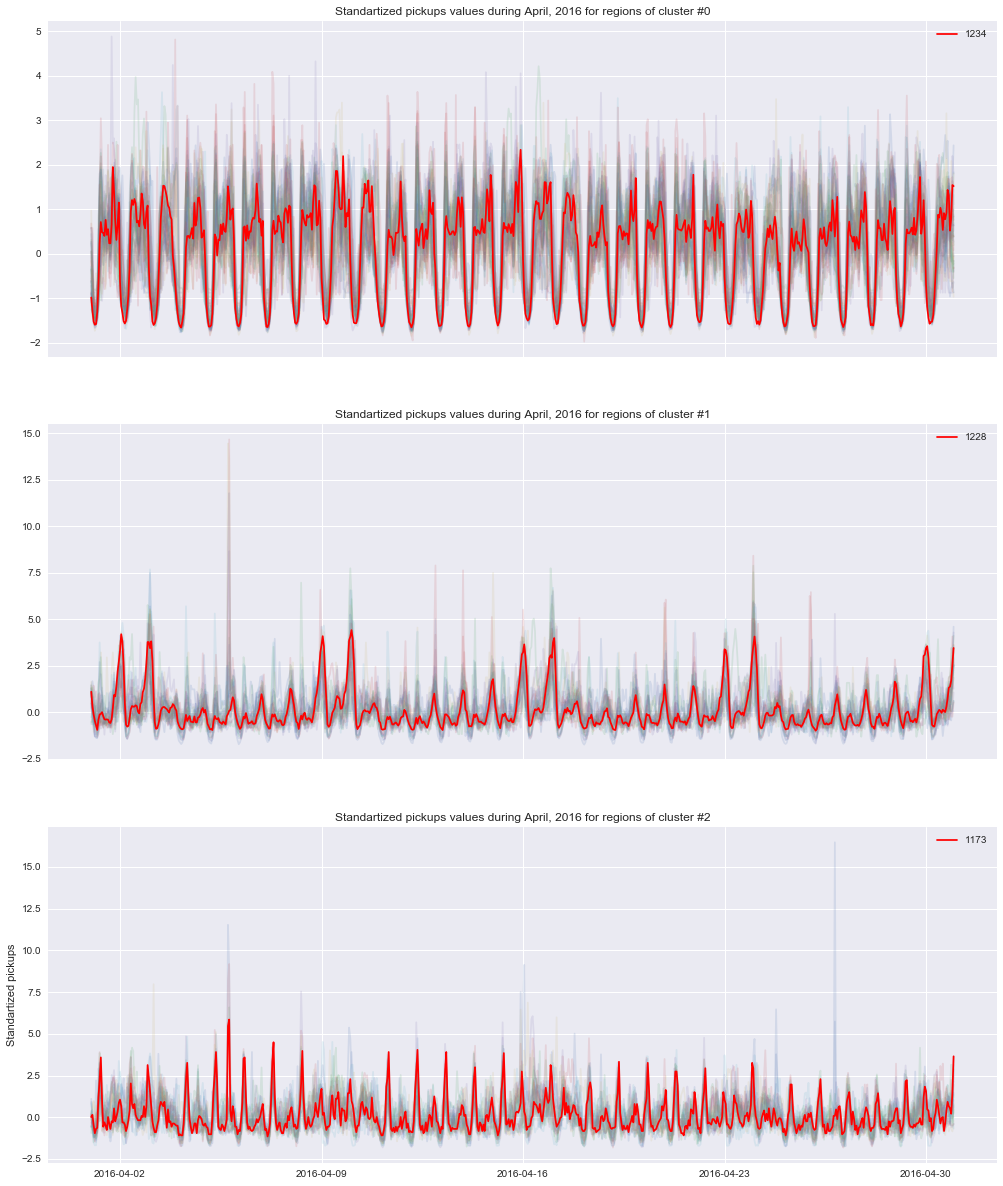

In [18]:
#npickups_scl_clstr_0.loc['2016-05', (npickups_scl_clstr_0.columns != representers_of_clusters[0])].plot(figsize = (17,7), alpha = 0.05)
fig, ax = plt.subplots(3, 1, figsize=(17,21), sharex = True)
for i, v in enumerate (representers_of_clusters):
    ax[i].plot(npickups_scl_clstr[i].loc['2016-04', (npickups_scl_clstr[i].columns != v)], alpha = 0.15)
    ax[i].plot(npickups_scl_clstr[i].loc['2016-04', v], c = 'r', )
    ax[i].set_title('Standartized pickups values during April, 2016 for regions of cluster #{}'.format(i))
    ax[i].legend()
plt.ylabel('Standartized pickups', )
plt.show()

Области разделены на кластеры и, судя по графикам, схожи с пределах своего кластера.

## 4.
В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).

Сделано в предыдущей части.

## 5.
Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!

In [19]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from itertools import product
import warnings
import statsmodels.api as sm
from scipy import stats
import scipy as sc
from itertools import product

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [20]:
trig_features = []
columns = []
timerange = pd.date_range(npickups_june_incl.index[0], npickups_june_incl.index[-1], freq = 'h')
t = np.arange(1, len(timerange) + 1)
for order in range (1, 51):
    for func in [np.sin, np.cos]:
        trig_features.append(1. * func(t * 2 * np.pi * (order + 1) / 168))
        columns.append(str(func)[-5:-2]+'_{}'.format(order))
trig_features = pd.DataFrame(trig_features).T
trig_features.columns = columns
trig_features.index = timerange
del columns

Функция, определенная ниже, создает $2 * K $ новых признаков, вычисляет коэффициенты линейной модели регрессии с лассо-регуляризацией и возвращает список фич с ненулевыми коэффициентами и саму модель, а также отрисовывает скор $(R ^ 2)$.

In [21]:
def regression_harmonics(y, features = trig_features, K = 50, show_plots = False, show_score = False):
    scores = []
    estimator = None
    end_time = np.argwhere(features.index == y.index[-1])[0][0] + 1 ##вычисляется для iloc вмето loc.
    if show_plots:
        for i in range(1, K + 1):
            X = features.iloc[:end_time, :(2*i)]
            y =        y[:end_time]
            estimator = Lasso()
            estimator.fit(X, y)
            scores.append([i, estimator.score(X,y)])
        scores = pd.DataFrame(scores)
        scores.columns = ['n_features', 'score']
        plt.figure(figsize=(15,8))
        plt.plot(scores.loc[:, 'n_features'], scores.loc[:, 'score'])
        plt.show()
        features_ids = np.argwhere(estimator.coef_).reshape(1, len(np.argwhere(estimator.coef_)))[0]
        features_names = X.columns[features_ids]
        X = features.iloc[:end_time, features_ids]
        estimator.fit(X, y)
    else:
        X = features.iloc[:end_time, :(2*K)]
        y =        y[:end_time]
        estimator = Lasso()
        estimator.fit(X, y)
        features_ids = np.argwhere(estimator.coef_).reshape(1, len(np.argwhere(estimator.coef_)))[0]
        if len(features_ids) == 0:
            X = features.iloc[:end_time, :(2*K)]
            y =        y[:end_time]
            estimator = Ridge()
            estimator.fit(X, y)
            features_ids = np.argwhere(estimator.coef_).reshape(1, len(np.argwhere(estimator.coef_)))[0]
        features_names = X.columns[features_ids]
        X = features.iloc[:end_time, features_ids]
        estimator.fit(X, y)
    if show_score:
        print len(features_ids), ' features selected with score: ', estimator.score(X,y)
    return features_names, estimator #Возвращает список имен фич и саму обученную модель

In [22]:
predictions = pd.DataFrame(np.nan, index = timerange, columns = ['A'])
predictions.drop('A', axis = 'columns', inplace = True)
for key in regions_clusters.iterkeys():
    predictions['{}_actual'.format(key)] = npickups_june_incl.loc[:, key]
predictions.tail()

,1783_actual,1076_actual,1077_actual,1075_actual,1377_actual,1376_actual,1378_actual,2068_actual,2069_actual,1388_actual,...,1178_actual,1285_actual,1284_actual,1287_actual,1286_actual,1281_actual,1280_actual,1283_actual,1282_actual,1684_actual
2016-06-30 19:00:00,311,190,135,116,5,4,6,104,9,21,...,604,313,72,86,276,1203,225,333,1727,44
2016-06-30 20:00:00,344,142,149,104,9,10,11,103,24,32,...,589,269,65,71,205,995,230,282,1457,27
2016-06-30 21:00:00,307,162,145,151,16,14,4,185,9,39,...,660,277,73,72,192,1123,210,279,1527,21
2016-06-30 22:00:00,387,168,103,106,17,38,17,169,12,27,...,803,223,56,77,168,1083,215,217,1206,19
2016-06-30 23:00:00,110,130,86,85,22,47,20,147,38,19,...,818,213,37,57,119,893,191,167,925,0


### Кластер 0, зона 1234

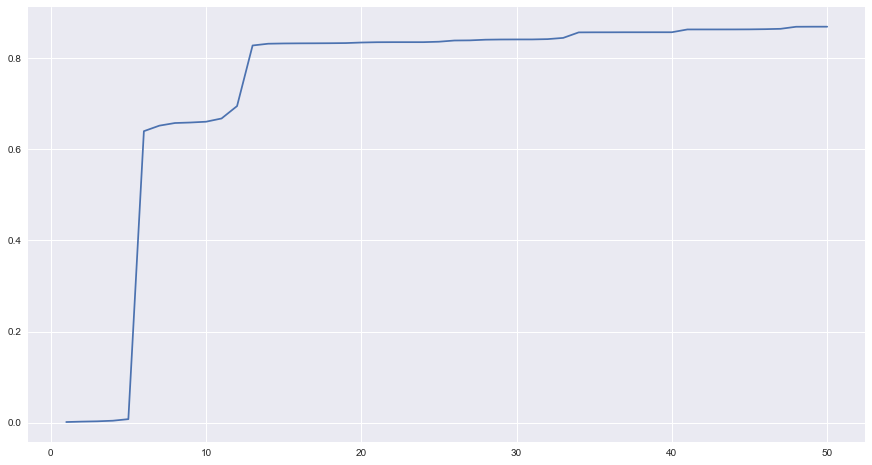

76  features selected with score:  0.869439475066


In [23]:
region = representers_of_clusters[0]
trig_features_0, LR_estimator_0 = regression_harmonics(npickups_clstr_0.loc[:, region], K = 50, show_plots=True, show_score = True)

В данном случае лассо-регуляризатор оставил явно больше ненулевых коэффициентов, чем достаточно для  относительное высокого скора.

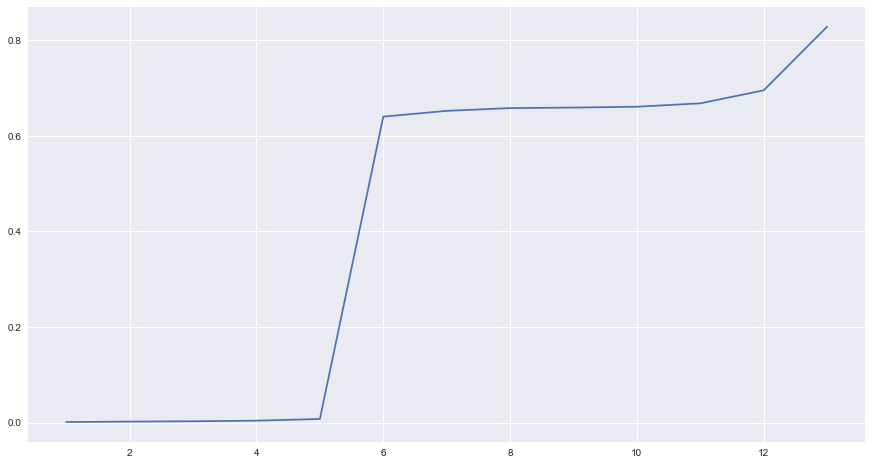

25  features selected with score:  0.82816885503


In [24]:
## Очистим датафрейм от новых фич
region = representers_of_clusters[0]
trig_features_0, LR_estimator_0 = regression_harmonics(npickups_clstr_0.loc[:, region], K = 13, show_plots=True, show_score = True)

### Кластер 1, зона 1228

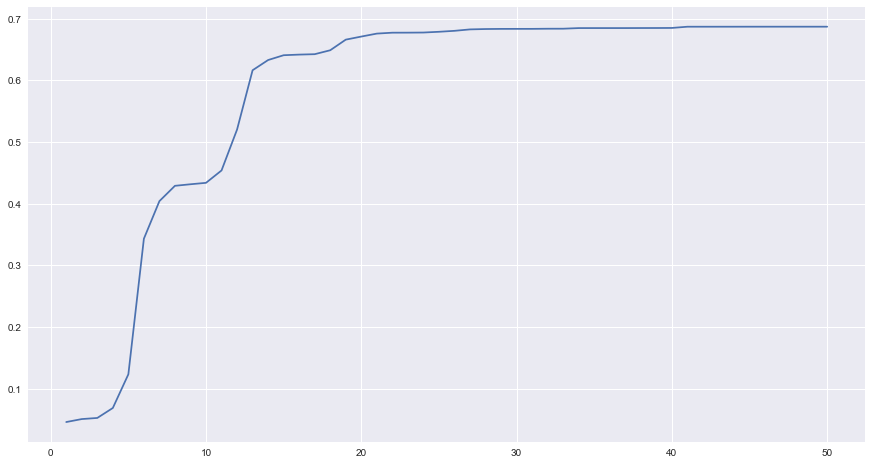

67  features selected with score:  0.687140500074


In [25]:
region = representers_of_clusters[1]
trig_features_1, LR_estimator_1 = regression_harmonics(npickups_clstr_1.loc[:, region], show_plots=True, show_score = True)

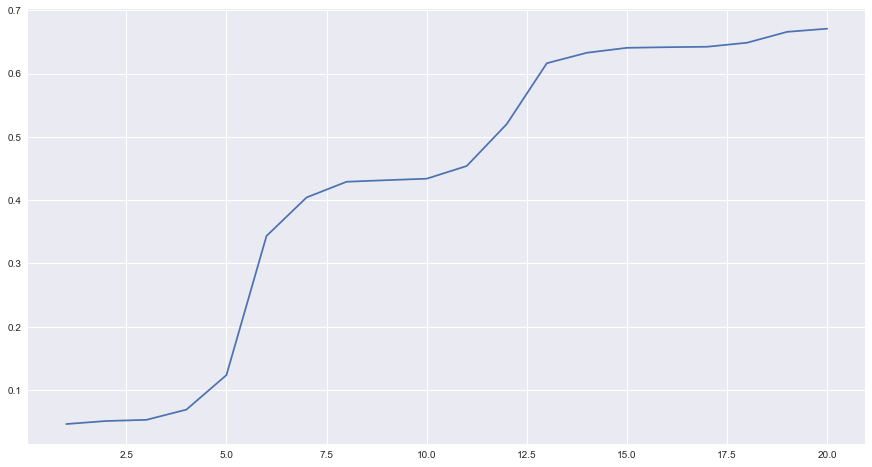

36  features selected with score:  0.67112966436


In [26]:
trig_features_1, LR_estimator_1 = regression_harmonics(npickups_clstr_1.loc[:, region], K = 20, show_plots=True, show_score = True)

## Кластер 2, зона 1173

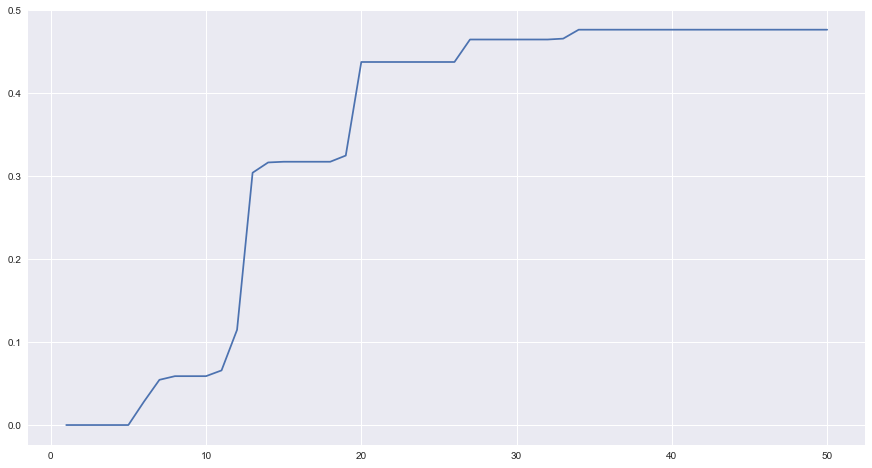

17  features selected with score:  0.476586108125


In [27]:
region = representers_of_clusters[2]
trig_features_2, LR_estimator_2 = regression_harmonics(npickups_clstr_2.loc[:, region], show_plots=True, show_score = True)

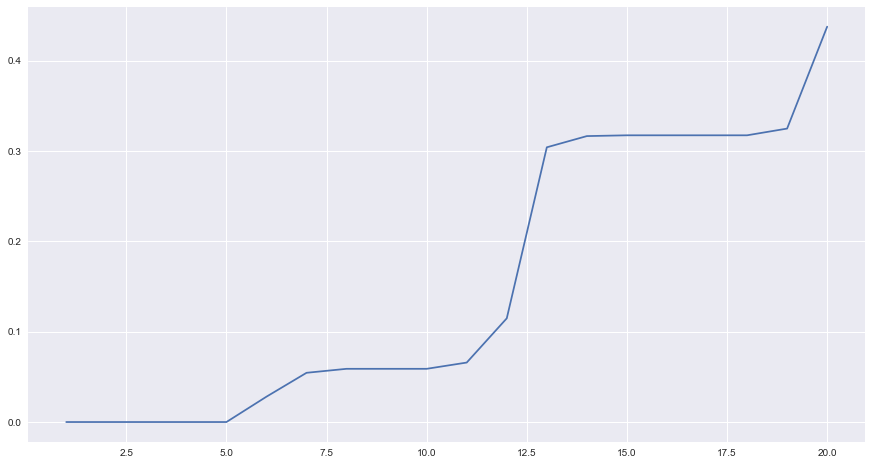

12  features selected with score:  0.437637690946


In [28]:
trig_features_2, LR_estimator_2 = regression_harmonics(npickups_clstr_2.loc[:, region], K = 20, show_plots=True, show_score = True)

Теперь, обкатав лассо-регрессию на кластерах, обучим оную для каждого региона, выделив значимые фичи. Затем расчитаем остатки от регрессии.

Сначала создаем массив [[имена_фич, модель]...] для кажой зоны.
Затем делаем 2 словаря, которые возвращают список фич или модель.

In [29]:
%%time
trig_features_names_AND_LR_estimators = [regression_harmonics(npickups.loc[:, key], K = 50)\
                                         for key in regions_clusters.iterkeys()]
trig_features_names = dict(zip(regions_clusters.keys(),
                               [v[0] for v in trig_features_names_AND_LR_estimators]))
LR_estimators       = dict(zip(regions_clusters.keys(),
                               [v[1] for v in trig_features_names_AND_LR_estimators]))

Wall time: 1.4 s


In [30]:
## Возвращает пресказания от линейной модели.В качестве параметров задается регион и список фич, 
# из которых функция самостоятельно выбирает нужные.
def LR_predict(region, X, estimators = LR_estimators, trig_features_names = trig_features_names):
    estimator                = estimators[region]
    features_names = trig_features_names[region]
    prediction = estimator.predict(X.loc[:, features_names])
    return prediction

In [31]:
## Проводит дифференцирование (неделя, неделя + 1 час) и отрисовывает результаты декомпозиции., 
def decompose_w_shift(data):
    """Do STL decomposition with  daily, and daily + 1 shift"""
    %pylab inline
    resid_diff_1 =         data - data.shift(24)
    resid_diff_2 = resid_diff_1 - resid_diff_1.shift(1) 
    
    plt.figure(figsize(15,7))
    sm.tsa.seasonal_decompose(data).plot()
    plt.title('W/o differencing')
    crit = sm.tsa.stattools.adfuller(data)[1]
    print "Критерий Дики-Фуллера для исходных данных: p = ", float.conjugate(crit)
    
    plt.figure(figsize(15,7))
    sm.tsa.seasonal_decompose(resid_diff_1[24:]).plot()
    plt.title('W weekly differencing')
    crit = sm.tsa.stattools.adfuller(resid_diff_1[24:])[1]
    print "Критерий Дики-Фуллера для дневного сдвига: p = ", float.conjugate(crit)
    
    plt.figure(figsize(15,7))
    sm.tsa.seasonal_decompose(resid_diff_2[24 + 1:]).plot()
    plt.title('W weekly + daily differencing')
    crit = sm.tsa.stattools.adfuller(resid_diff_2[24 + 1:])[1]
    print "Критерий Дики-Фуллера для дневного и единичного сдвига: p = ", float.conjugate(crit)
    
    return resid_diff_1, resid_diff_2

In [32]:
%%time
for region in regions_clusters.iterkeys():
    predictions['{}_LR_prediction'.format(region)] = LR_predict(region, trig_features)

Wall time: 269 ms


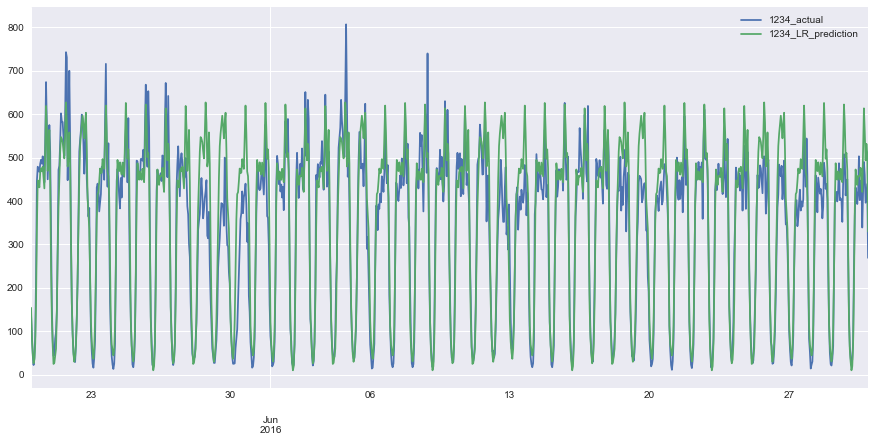

In [33]:
predictions.loc['2016-05-20':'2016-06-30',['1234_actual', '1234_LR_prediction']].plot(figsize = (15,7))
plt.show()

In [34]:
%%time
for region in regions_clusters.iterkeys():
    predictions['{}_LR_residual'.format(region)] = \
    predictions.loc[:, '{}_LR_prediction'.format(region)] - predictions.loc[:, '{}_actual'.format(region)]

Wall time: 83 ms


Остатки от предсказаний линейной модели вычислены для всего промежутка времени по июнь включительно. При этом данные за май и июнь не использовались при обучении модели. Теперь определим параметры моделей ARIMA.

In [35]:
train_end_time = pd.to_datetime('2016-04-30 23')

### Кластер 0, зона 1234

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['product', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Критерий Дики-Фуллера для исходных данных: p =  8.19247036639e-10
Критерий Дики-Фуллера для дневного сдвига: p =  2.04045711755e-21
Критерий Дики-Фуллера для дневного и единичного сдвига: p =  4.32253652118e-29


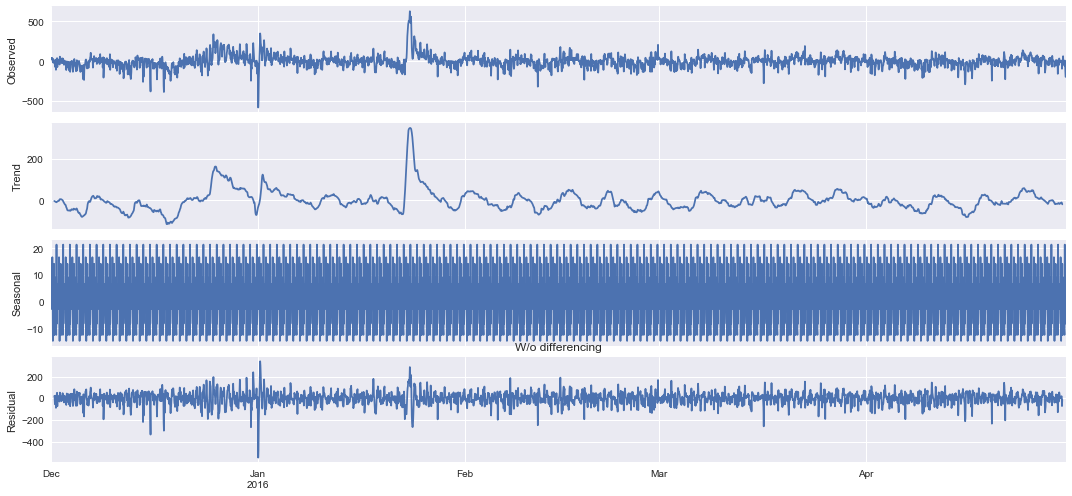

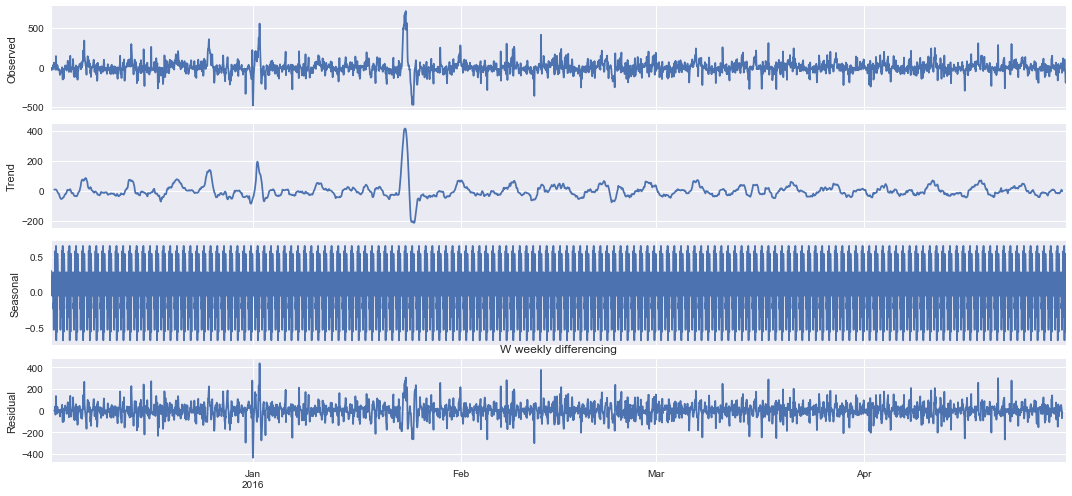

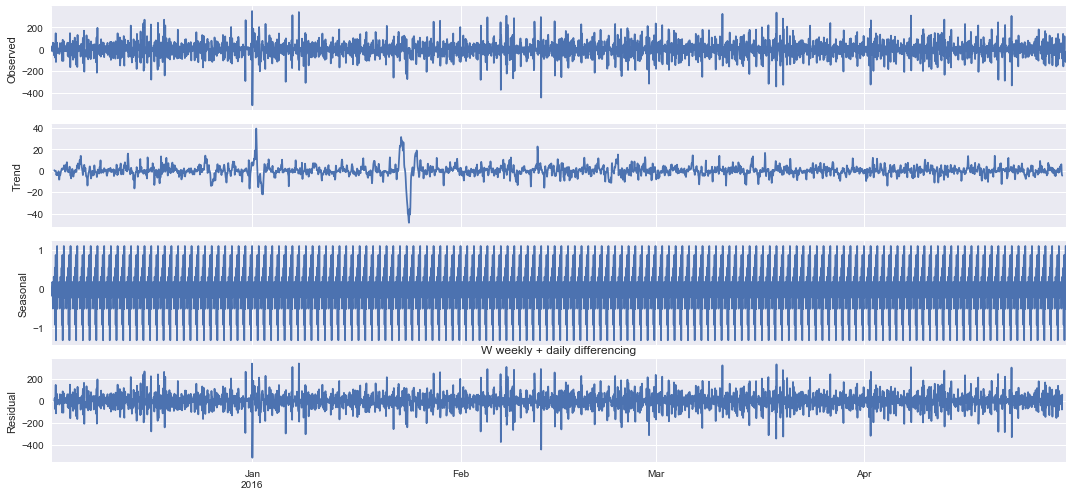

In [36]:
resid_diff_1_1234, resid_diff_2_1234 = decompose_w_shift(predictions.loc[:train_end_time, '1234_LR_residual'])

### Кластер 1, зона 1228

Populating the interactive namespace from numpy and matplotlib
Критерий Дики-Фуллера для исходных данных: p =  9.04345390902e-13
Критерий Дики-Фуллера для дневного сдвига: p =  6.62489367003e-14
Критерий Дики-Фуллера для дневного и единичного сдвига: p =  4.28652190257e-27


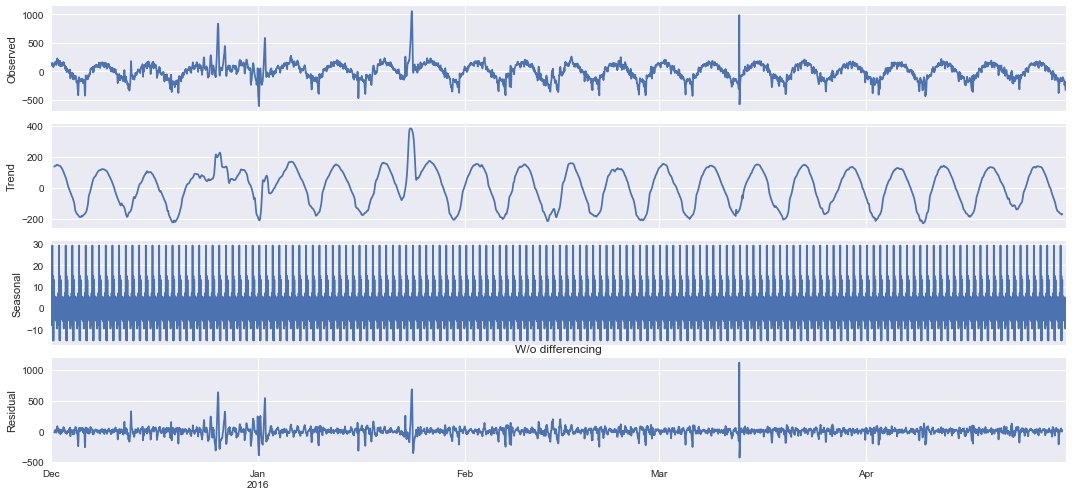

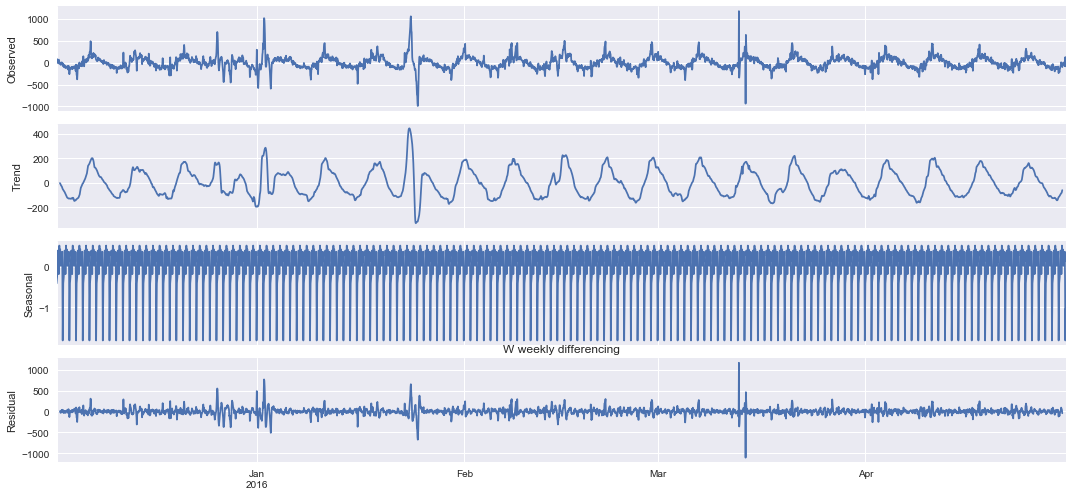

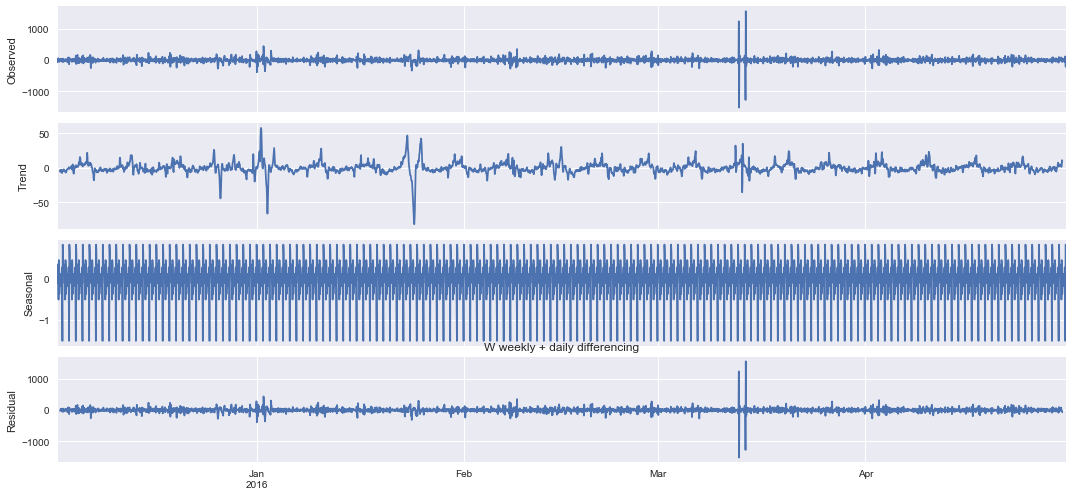

In [37]:
resid_diff_1_1228, resid_diff_2_1228 = decompose_w_shift(predictions.loc[:train_end_time, '1228_LR_residual'])

### Кластер 2, зона 1173

Populating the interactive namespace from numpy and matplotlib
Критерий Дики-Фуллера для исходных данных: p =  8.8275148226e-10
Критерий Дики-Фуллера для дневного сдвига: p =  9.66436970483e-26
Критерий Дики-Фуллера для дневного и единичного сдвига: p =  1.34605786202e-29


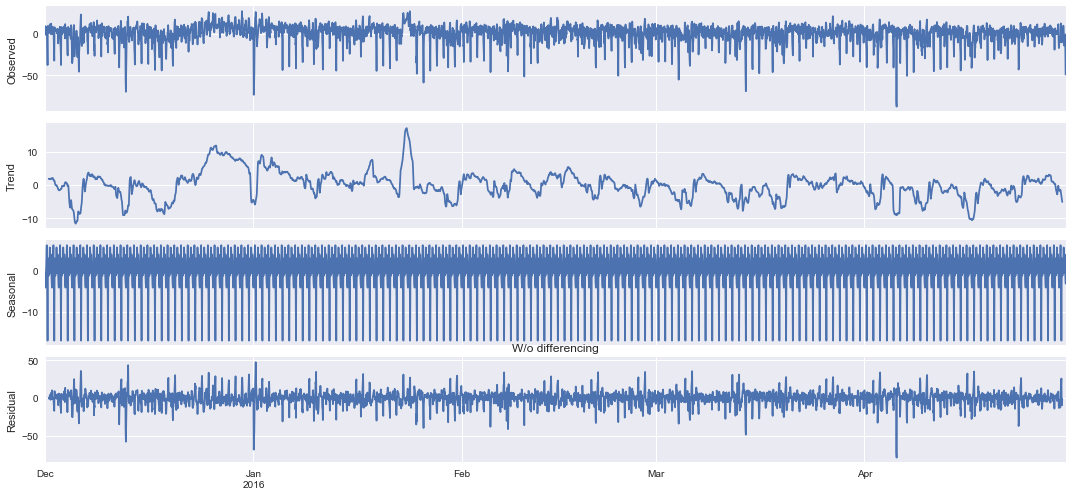

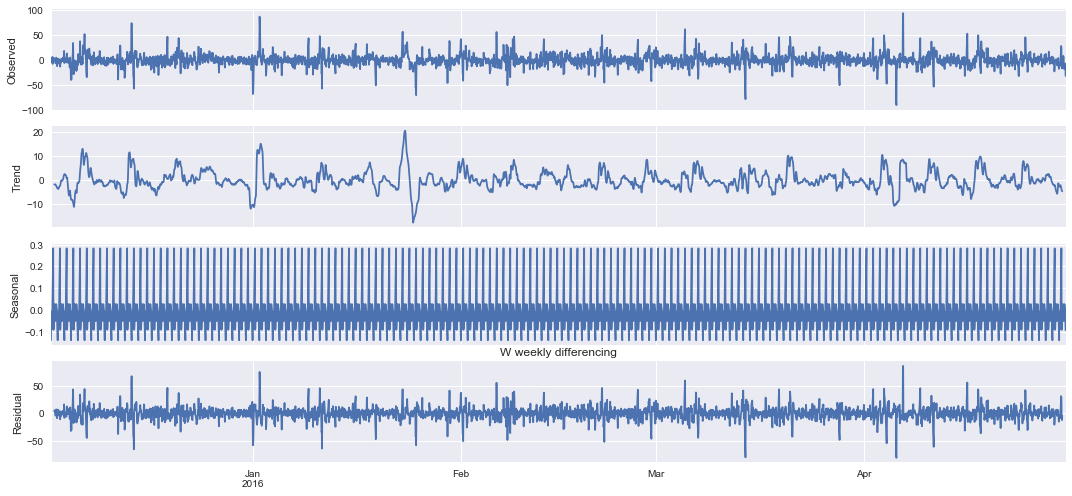

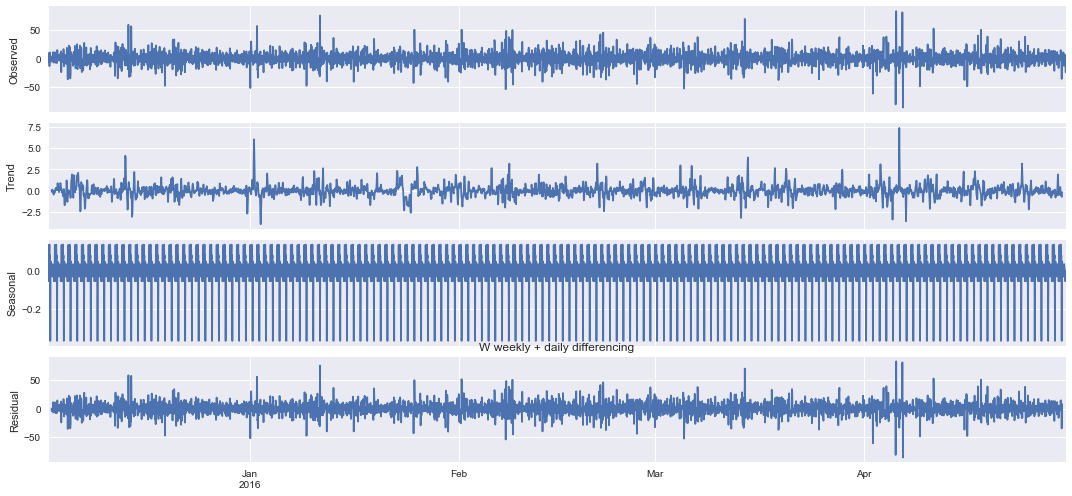

In [38]:
resid_diff_1_1173, resid_diff_2_1173 = decompose_w_shift(predictions.loc[:train_end_time, '1173_LR_residual'])

Во всех 3 случаях наилучшим образом себя показало 2-кратное дифференцирование (сезонное + обычное), однако, на практике мы вряд ли сможем его использовать из за крайне требовательного к ресурсам процесса обучения аримы с большим D, которое в нашем случае будет равно 7.
Теперь займемся выбором начальных параметров p, q, P, Q.

### Кластер 0, зона 1234

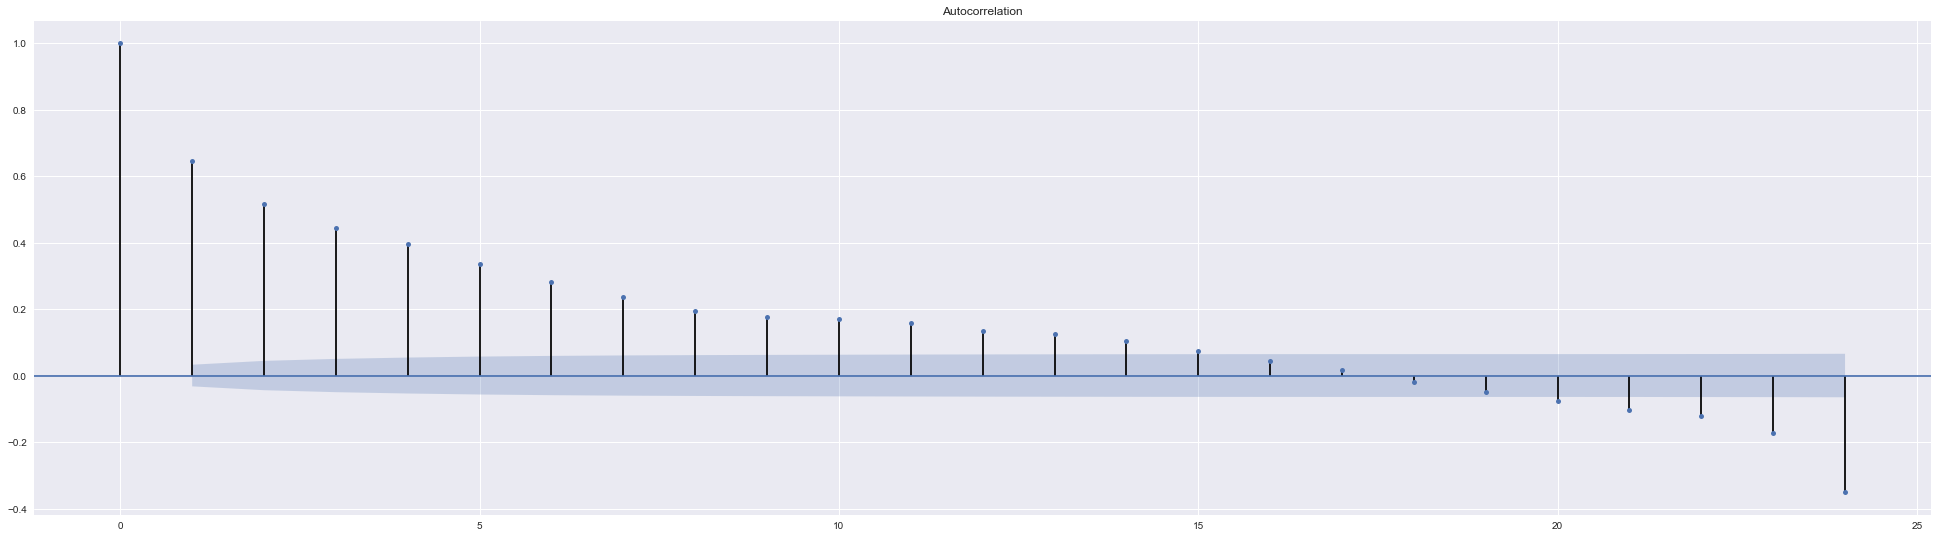

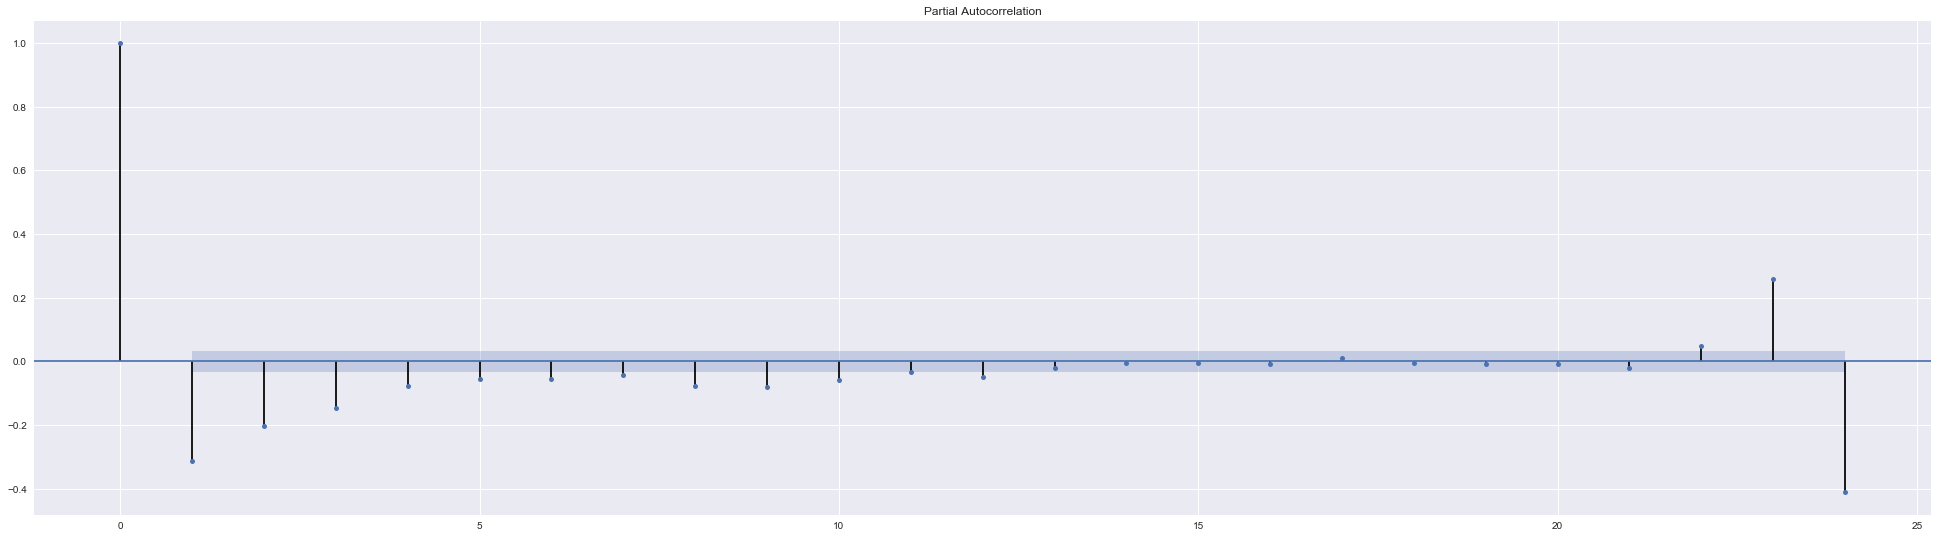

In [39]:
plt.figure(figsize=(34,20))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_diff_1_1234[24 + 1:].squeeze(), lags=24, ax=ax)
plt.show()
plt.figure(figsize=(34,20))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_diff_2_1234[24 + 1:].squeeze(), lags=24, ax=ax)
plt.show()

### Кластер 1, зона 1228

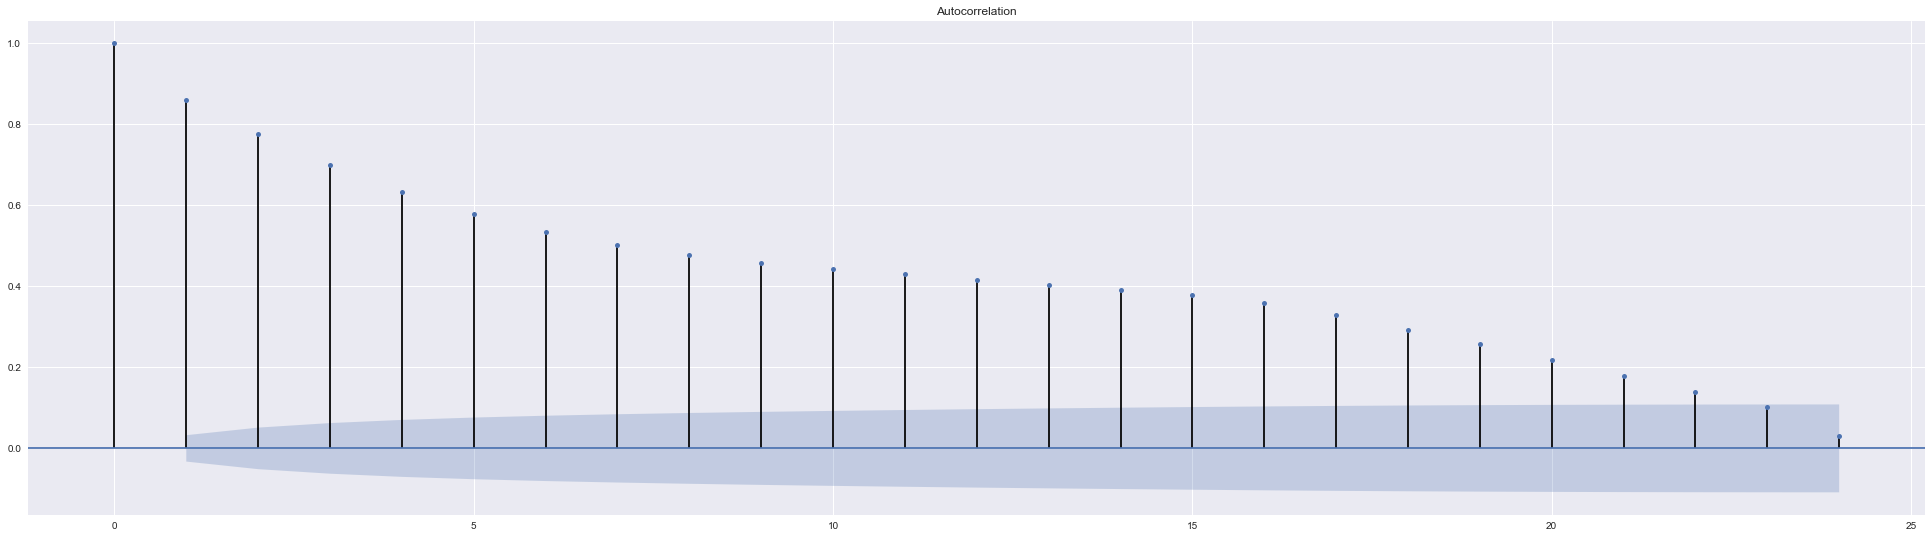

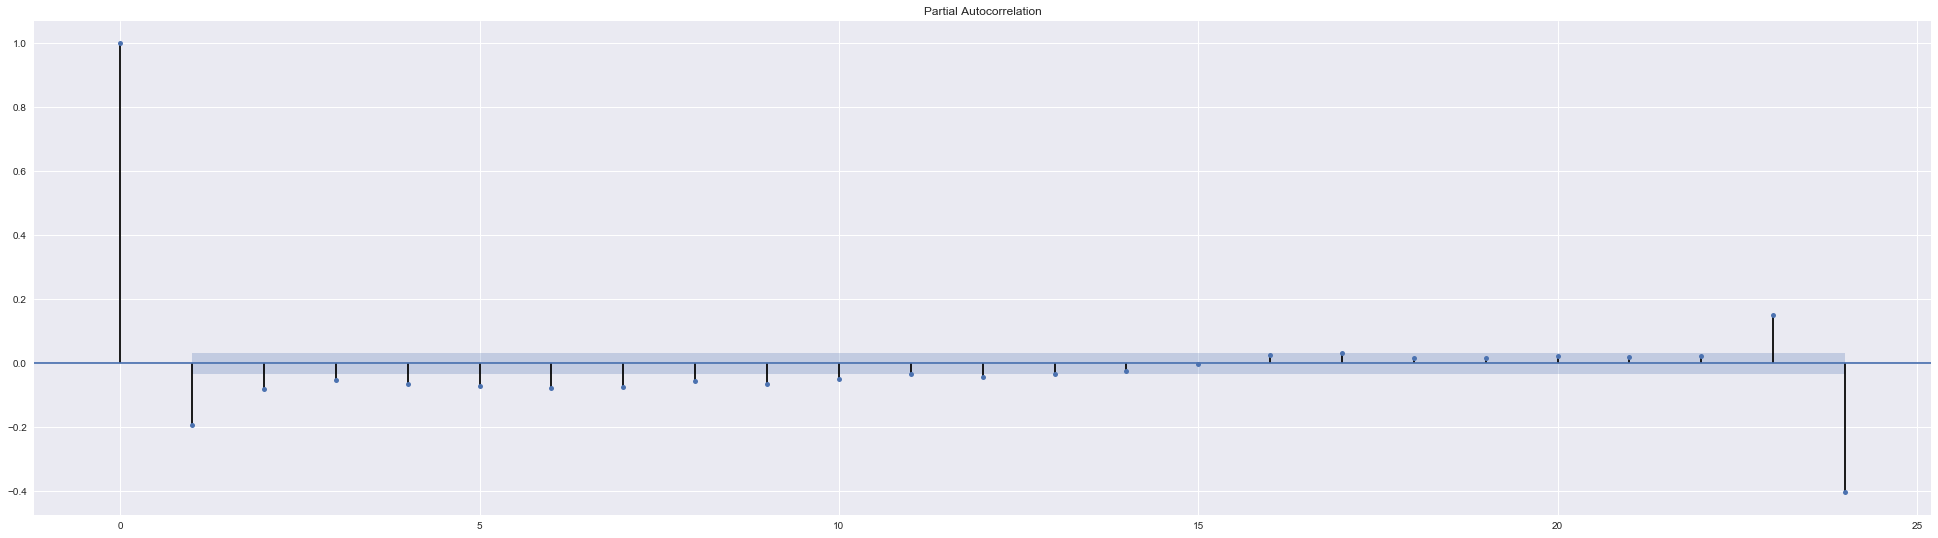

In [40]:
plt.figure(figsize=(34,20))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_diff_1_1228[24:].squeeze(), lags=24, ax=ax)
plt.show()
plt.figure(figsize=(34,20))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_diff_2_1228[24 + 1:].squeeze(), lags=24, ax=ax)
plt.show()

### Кластер 2, зона 1173

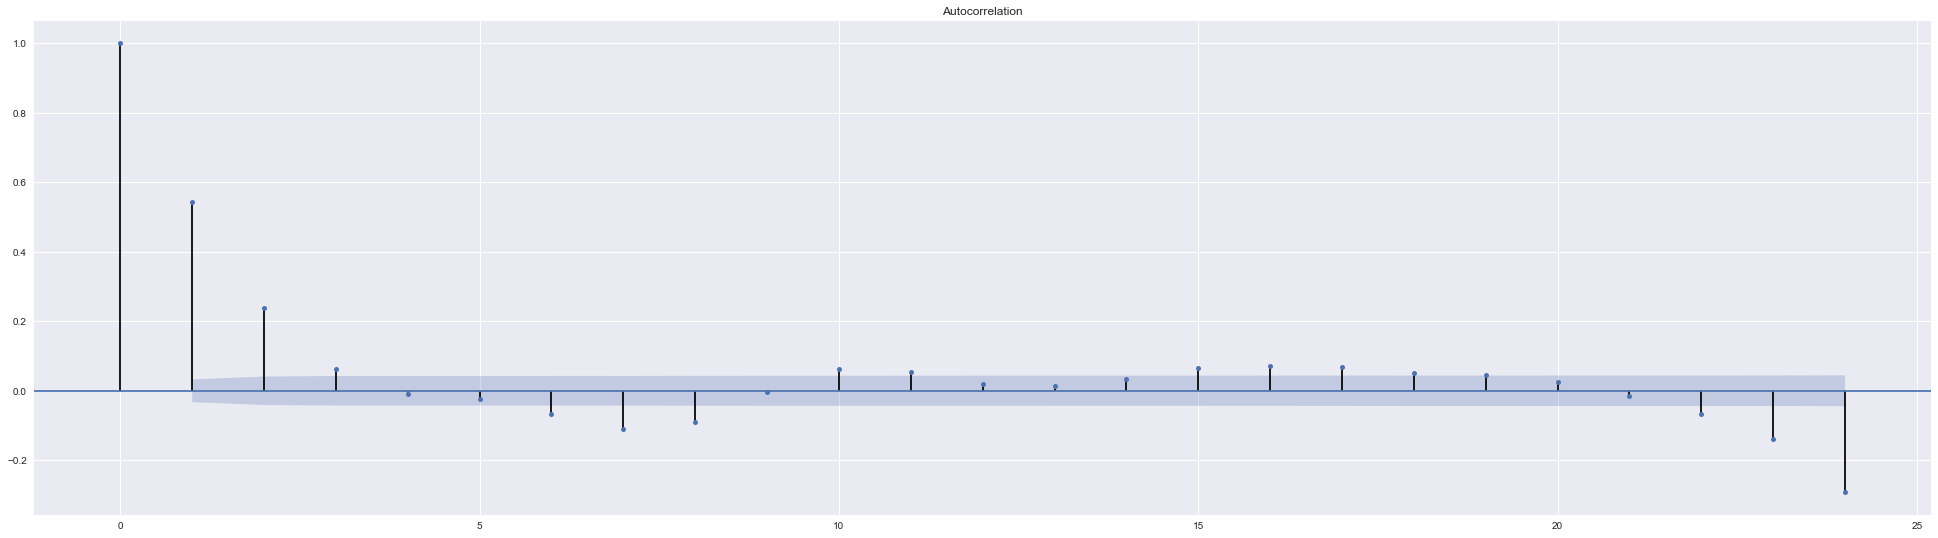

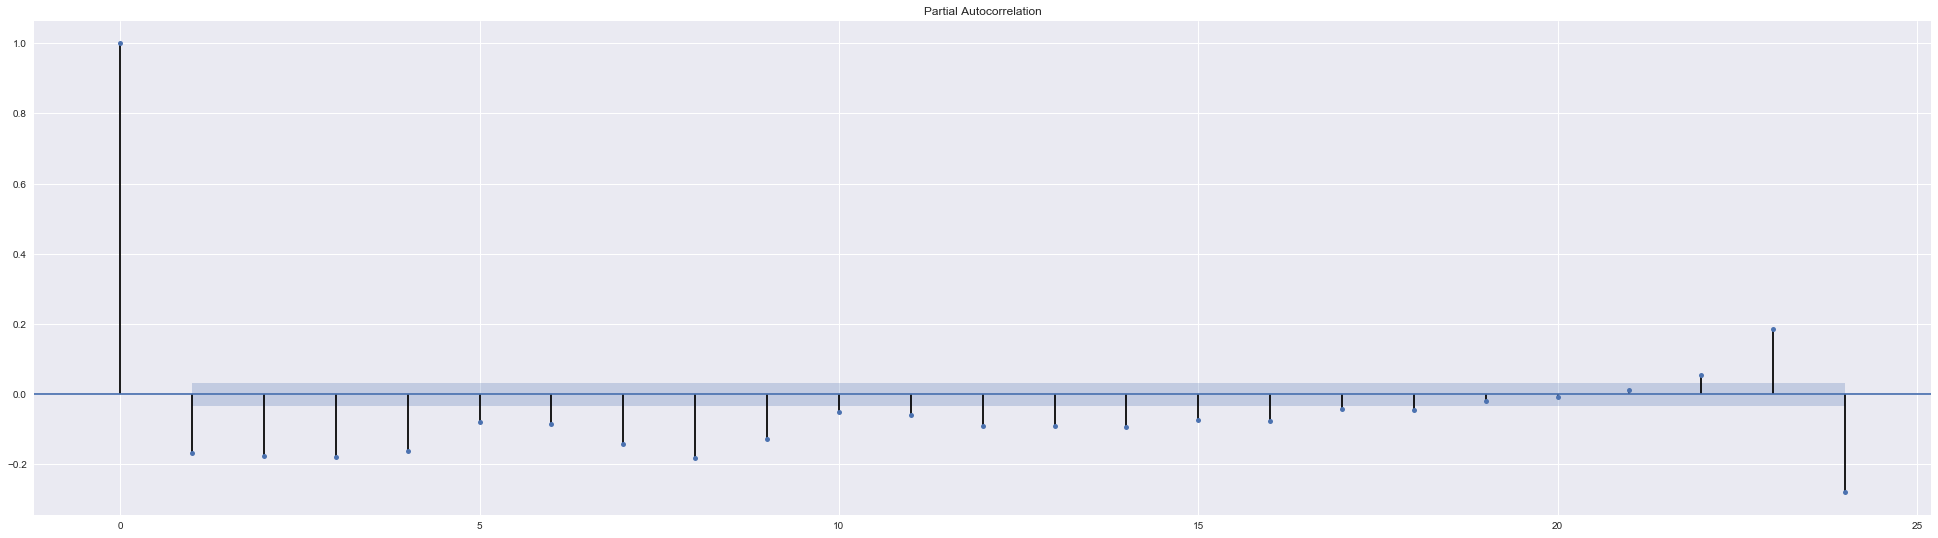

In [41]:
plt.figure(figsize=(34,20))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(resid_diff_1_1173[24:].squeeze(), lags=24, ax=ax)
plt.show()
plt.figure(figsize=(34,20))
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(resid_diff_2_1173[24 + 1:].squeeze(), lags=24, ax=ax)
plt.show()

Начальное значение для параметра $Q  ∗  $S даёт номер последнего сезонного лага, при котором автокорреляция значима.
Параметр $q$ задаётся номером последнего несезонного лага, при котором автокорреляция значима.

Начальное приближение для параметра $P ∗$S задаёт номер последнего сезонного лага, при котором частичная автокорреляция значима.  Аналогично, p задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима.

### Выбор параметров p, q, P, Q:

#### Кластер 0, зона 1281: 
    p = 4, q = 14, P = 7, Q = 7.
#### Кластер 1, зона 1436: 
    p = 1, q = 21, P = 7, Q = 7.
#### Кластер 2, зона 1274:
    p = 4, q = 2, P = 7, Q = 7.

По причине отсутствия необходимых вычислительных ресурсов, ограничимся 2 значениями для каждого параметра (p,q,P,Q) и 10 вариантами перебора параметров для класса моделей ARIMA. 

In [42]:
from itertools import product
p0, q0, P0, Q0 = 4, 14, 1, 1
p1, q1, P1, Q1 = 1, 21, 1, 1
p2, q2, P2, Q2 = 4, 2, 1, 1
d = 1
D = 1

ps = range(0, 2)
qs = range(0, 2)
ds = range(0, 2)
Ds = range(0, 2)
Ps = range(0, 2)
Qs = range(0, 2)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print 'Для перебора выбрано  {} варианта.'.format(len(parameters_list))

Для перебора выбрано  16 варианта.


## 6.
Для каждой из R географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

In [43]:
import time
from scipy.linalg import LinAlgError

Так как процесс обучения ARIMAX с экзогенными фичами занимает слишком много времени, обучим ARIMA на остатках от обычной линейной регрессии, а затем сложим предсказания. Получится композиция из 2 моделей.


Выберем оптимальные параметры для аримы

## Кластер 0.

In [44]:
import time

In [45]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    now = time.time()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog = predictions.loc[:train_end_time, '1234_LR_residual'].astype('float'), 
                                        order=            (param[0], 1, param[1]),
                                        exog = None).fit(disp=-1)
        
        print('Ok parameters:', param, '   duration, sec: ', round(float(time.time() - now), 2), '   AIC: ', model.aic)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('Singular matrix:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
model_0 = best_model
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 0, 0, 1))
('wrong parameters:', (0, 0, 1, 0))
('wrong parameters:', (0, 0, 1, 1))
('Ok parameters:', (0, 1, 0, 0), '   duration, sec: ', 0.93, '   AIC: ', 39389.929141606597)
('Ok parameters:', (0, 1, 0, 1), '   duration, sec: ', 0.88, '   AIC: ', 39389.929141606597)
('Ok parameters:', (0, 1, 1, 0), '   duration, sec: ', 0.92, '   AIC: ', 39389.929141606597)
('Ok parameters:', (0, 1, 1, 1), '   duration, sec: ', 0.88, '   AIC: ', 39389.929141606597)
('Ok parameters:', (1, 0, 0, 0), '   duration, sec: ', 0.81, '   AIC: ', 39516.497549932305)
('Ok parameters:', (1, 0, 0, 1), '   duration, sec: ', 0.82, '   AIC: ', 39516.497549932305)
('Ok parameters:', (1, 0, 1, 0), '   duration, sec: ', 0.75, '   AIC: ', 39516.497549932305)
('Ok parameters:', (1, 0, 1, 1), '   duration, sec: ', 0.77, '   AIC: ', 39516.497549932305)
('Ok parameters:', (1, 1, 0, 0), '   duration, sec: ', 1.04, '   AIC: ', 39168.050511595342)
('Ok parameters:', 

In [46]:
print(model_0.summary())

                           Statespace Model Results                           
Dep. Variable:       1234_LR_residual   No. Observations:                 3648
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -19581.025
Date:                Tue, 24 Oct 2017   AIC                          39168.051
Time:                        15:15:40   BIC                          39186.656
Sample:                    12-01-2015   HQIC                         39174.677
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5789      0.010     57.358      0.000       0.559       0.599
ma.L1         -0.9355      0.005   -205.690      0.000      -0.944      -0.927
sigma2      2697.2290     37.098     72.705      0.0

## Кластер 1.

In [47]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    now = time.time()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog = predictions.loc[:train_end_time, '1228_LR_residual'].astype('float'), 
                                        order=         (param[0], 1, param[1]),
                                        exog = None).fit(disp=-1)
        
        print('Ok parameters:', param, '   duration, min: ', round(float(time.time() - now) / 60))
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('Singular matrix:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
model_1 = best_model
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 0, 0, 1))
('wrong parameters:', (0, 0, 1, 0))
('wrong parameters:', (0, 0, 1, 1))
('Ok parameters:', (0, 1, 0, 0), '   duration, min: ', 0.0)
('Ok parameters:', (0, 1, 0, 1), '   duration, min: ', 0.0)
('Ok parameters:', (0, 1, 1, 0), '   duration, min: ', 0.0)
('Ok parameters:', (0, 1, 1, 1), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 0, 0), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 0, 1), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 1, 0), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 1, 1), '   duration, min: ', 0.0)
('Ok parameters:', (1, 1, 0, 0), '   duration, min: ', 0.0)
('Ok parameters:', (1, 1, 0, 1), '   duration, min: ', 0.0)
('Ok parameters:', (1, 1, 1, 0), '   duration, min: ', 0.0)
('Ok parameters:', (1, 1, 1, 1), '   duration, min: ', 0.0)
Wall time: 10.6 s


In [48]:
print(model_1.summary())

                           Statespace Model Results                           
Dep. Variable:       1228_LR_residual   No. Observations:                 3648
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -19982.391
Date:                Tue, 24 Oct 2017   AIC                          39970.782
Time:                        15:15:51   BIC                          39989.387
Sample:                    12-01-2015   HQIC                         39977.408
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7111      0.008     84.138      0.000       0.694       0.728
ma.L1         -0.8792      0.008   -103.935      0.000      -0.896      -0.863
sigma2      3362.1012     13.998    240.183      0.0

## Кластер 2.

In [49]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    now = time.time()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog = predictions.loc[:train_end_time, '1173_LR_residual'].astype('float'), 
                                        order=         (param[0], 1, param[1]),
                                        exog = None).fit(disp=-1)
        
        print('Ok parameters:', param, '   duration, min: ', round(float(time.time() - now) / 60))
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    except LinAlgError:
        print('Singular matrix:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
model_2 = best_model
warnings.filterwarnings('default')

('wrong parameters:', (0, 0, 0, 0))
('wrong parameters:', (0, 0, 0, 1))
('wrong parameters:', (0, 0, 1, 0))
('wrong parameters:', (0, 0, 1, 1))
('Ok parameters:', (0, 1, 0, 0), '   duration, min: ', 0.0)
('Ok parameters:', (0, 1, 0, 1), '   duration, min: ', 0.0)
('Ok parameters:', (0, 1, 1, 0), '   duration, min: ', 0.0)
('Ok parameters:', (0, 1, 1, 1), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 0, 0), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 0, 1), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 1, 0), '   duration, min: ', 0.0)
('Ok parameters:', (1, 0, 1, 1), '   duration, min: ', 0.0)
('wrong parameters:', (1, 1, 0, 0))
('wrong parameters:', (1, 1, 0, 1))
('wrong parameters:', (1, 1, 1, 0))
('wrong parameters:', (1, 1, 1, 1))
Wall time: 6.37 s


In [50]:
print(model_2.summary())

                           Statespace Model Results                           
Dep. Variable:       1173_LR_residual   No. Observations:                 3648
Model:               SARIMAX(0, 1, 1)   Log Likelihood              -13675.607
Date:                Tue, 24 Oct 2017   AIC                          27355.214
Time:                        15:15:58   BIC                          27367.617
Sample:                    12-01-2015   HQIC                         27359.631
                         - 04-30-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.1463      0.010    -14.108      0.000      -0.167      -0.126
sigma2       105.8239      1.340     78.958      0.000     103.197     108.451
Ljung-Box (Q):                     1434.36   Jarque-

После того, как мы подготовили предсказания и невязки после применения линейной регрессии, обучим ARIMA-модели для кажой зоны с соответствующими их кластерам гиперпараметрами.

In [51]:
%%time
ARIMA_estimators = []
i = 1
for region in regions_clusters.keys():
    now = time.time()
    endog = predictions.loc[:, '{}_LR_residual'.format(region)]
    if regions_clusters[region] == 2:
        p, q, P, Q, = 0, 1, 1, 1
    else:
        p, q, P, Q, = 1, 1, 1, 1
    # обучим модель на данных для обучения
    mod_fit = sm.tsa.statespace.SARIMAX(endog[:'2016-04'], 
                                        order=(p,1,q), 
                                        enforce_stationarity=False, enforce_invertibility=False)
    res_fit = mod_fit.fit(disp=-1)
    model = sm.tsa.statespace.SARIMAX(endog[:], order=(p,1,q), enforce_stationarity=False, 
                                      enforce_invertibility=False)
    model.initialize_known(res_fit.predicted_state[:, -1], res_fit.predicted_state_cov[:, :, -1])
    res_model = model.smooth(res_fit.params)
    ARIMA_estimators.append(res_model)
    print('Iteration : {},  region: {}, duration, min: {}'.format(i, region, round(float(time.time() - now) / 60)))
    i=i+1
del i
ARIMA_estimators_till_may = dict(zip(regions_clusters.keys(),
                               [v for v in ARIMA_estimators]))

Iteration : 1,  region: 1783, duration, min: 0.0
Iteration : 2,  region: 1076, duration, min: 0.0
Iteration : 3,  region: 1077, duration, min: 0.0
Iteration : 4,  region: 1075, duration, min: 0.0
Iteration : 5,  region: 1377, duration, min: 0.0
Iteration : 6,  region: 1376, duration, min: 0.0
Iteration : 7,  region: 1378, duration, min: 0.0
Iteration : 8,  region: 2068, duration, min: 0.0
Iteration : 9,  region: 2069, duration, min: 0.0
Iteration : 10,  region: 1388, duration, min: 0.0
Iteration : 11,  region: 1389, duration, min: 0.0
Iteration : 12,  region: 1384, duration, min: 0.0
Iteration : 13,  region: 1385, duration, min: 0.0
Iteration : 14,  region: 1386, duration, min: 0.0
Iteration : 15,  region: 1387, duration, min: 0.0
Iteration : 16,  region: 1380, duration, min: 0.0
Iteration : 17,  region: 1382, duration, min: 0.0
Iteration : 18,  region: 1383, duration, min: 0.0
Iteration : 19,  region: 1128, duration, min: 0.0
Iteration : 20,  region: 1129, duration, min: 0.0
Iteration

In [52]:
%%time
for region in regions_clusters.iterkeys():
    for t in range (1, 7):
        name = 'test_{}_ARIMA_prediction_dt_{}'.format(region, t)
        predictions[name] = np.NaN
i = 1
        
for region in regions_clusters.iterkeys():
    now = time.time()
    for hour in predictions.loc['2016-04-30 23':'2016-05-31 17', '{}_actual'.format(region)].index:
        srt = hour + dt.timedelta(hours=1)
        end = hour + dt.timedelta(hours=6)
        prediction = ARIMA_estimators_till_may[region].predict(srt, end, dynamic = True)
        for t in range (1, 7):
            predictions.loc[hour, 'test_{}_ARIMA_prediction_dt_{}'.format(region, t)] = prediction[t - 1]
    print('Iteration : {},  region: {}, duration, min: {}'.format(i, region, round(float(time.time() - now) / 60)))
    i = i + 1

Iteration : 1,  region: 1783, duration, min: 0.0
Iteration : 2,  region: 1076, duration, min: 0.0
Iteration : 3,  region: 1077, duration, min: 0.0
Iteration : 4,  region: 1075, duration, min: 0.0
Iteration : 5,  region: 1377, duration, min: 0.0
Iteration : 6,  region: 1376, duration, min: 0.0
Iteration : 7,  region: 1378, duration, min: 0.0
Iteration : 8,  region: 2068, duration, min: 0.0
Iteration : 9,  region: 2069, duration, min: 0.0
Iteration : 10,  region: 1388, duration, min: 0.0
Iteration : 11,  region: 1389, duration, min: 0.0
Iteration : 12,  region: 1384, duration, min: 0.0
Iteration : 13,  region: 1385, duration, min: 0.0
Iteration : 14,  region: 1386, duration, min: 0.0
Iteration : 15,  region: 1387, duration, min: 0.0
Iteration : 16,  region: 1380, duration, min: 0.0
Iteration : 17,  region: 1382, duration, min: 0.0
Iteration : 18,  region: 1383, duration, min: 0.0
Iteration : 19,  region: 1128, duration, min: 0.0
Iteration : 20,  region: 1129, duration, min: 0.0
Iteration

In [54]:
%%time
for region in regions_clusters.iterkeys():
    for t in range (1, 7):
        name = 'test_{}_final_dt_{}'.format(region, t)
        predictions[name] = np.NaN
        
for region in regions_clusters.iterkeys():
    for t in range (1, 7):
        name_of_LR_prediction       = '{}_LR_prediction'.format(region)
        name_of_ARIMA_prediction    = 'test_{}_ARIMA_prediction_dt_{}'.format(region, t)
        name                     = 'test_{}_final_dt_{}'.format(region, t)
        predictions[name] =  predictions.loc[:, name_of_LR_prediction].shift(-t) -\
                            predictions.loc[:, name_of_ARIMA_prediction]

Wall time: 789 ms


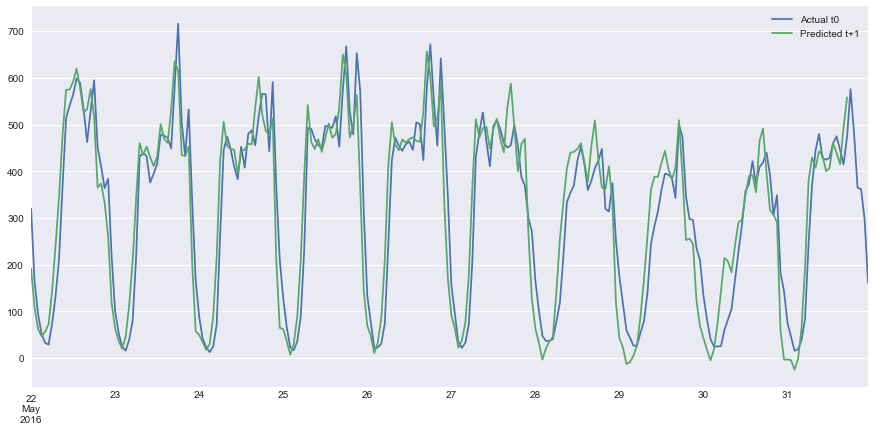

In [120]:
predictions.loc['2016-05-22':'2016-05-31', '1234_actual'].plot(label = 'Actual t0')
predictions.loc['2016-05-22':'2016-05-31', 'test_1234_final_dt_1'].plot(label = 'Predicted t+1')
plt.legend()
plt.show()

In [56]:
for region in regions_clusters.iterkeys():
    for t in range(1, 7):
        name_of_final_prediction = 'test_{}_final_dt_{}'.format(region, t)
        name_of_actual_values = '{}_actual'.format(region)
        name = 'test_{}_distance_dt_{}'.format(region, t)
        predictions[name] =  np.abs(predictions.loc[:, name_of_final_prediction].values -\
                                predictions.loc[:, name_of_actual_values].values)

Посчитаем контрольную метрику для мая:

$$ Q_{may} = \frac{1}{R * 739 * 6} \sum_{i=1}^R  \sum_{T=2016.04.30 23:00}^{2016.05.31 17:00} \sum_{i=1}^6 {\left| y_{T|T+i} - y_{T+i} \right|}$$

In [115]:
distances = pd.DataFrame(index=predictions.index)
for region in regions_clusters.iterkeys():
    for t in range(1, 7):
        name_pred = 'test_{}_final_dt_{}'.format(region, t)
        name_act  = '{}_actual'.format(region)
        name      = 'resid_{}_final_dt_{}'.format(region, t)
        residual = predictions.loc[:, name_act].shift(-t) - \
                   predictions.loc[:, name_pred]
        distances[name] = np.abs(residual)
distances = distances.dropna()

In [116]:
metrics = distances.sum().sum()/float(distances.shape[0] * distances.shape[1])
print 'Искомая метрика составляет: ', round(metrics, 3)

Искомая метрика составляет:  22.507


## 7. 
Для каждой из R географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [58]:
import datetime as dt

Снова обучим модель для каждой зоны, но теперь используем данные за май.

In [59]:
%%time
ARIMA_estimators = []
i = 1
for region in regions_clusters.keys():
    now = time.time()
    endog = predictions.loc[:, '{}_LR_residual'.format(region)]
    if regions_clusters[region] == 2:
        p, q, P, Q, = 0, 1, 8, 1
    else:
        p, q, P, Q, = 6, 1, 8, 1
    # обучим модель на данных для обучения
    mod_fit = sm.tsa.statespace.SARIMAX(endog[:'2016-05'], 
                                        order=(p,1,q), 
                                        enforce_stationarity=False, enforce_invertibility=False)
    res_fit = mod_fit.fit(disp=-1)
    model = sm.tsa.statespace.SARIMAX(endog[:], order=(p,1,q), enforce_stationarity=False, 
                                      enforce_invertibility=False)
    model.initialize_known(res_fit.predicted_state[:, -1], res_fit.predicted_state_cov[:, :, -1])
    res_model = model.smooth(res_fit.params)
    ARIMA_estimators.append(res_model)
    print('Iteration : {},  region: {}, duration, min: {}'.format(i, region, round(float(time.time() - now) / 60)))
    i=i+1
del i
ARIMA_estimators_till_june = dict(zip(regions_clusters.keys(),
                               [v for v in ARIMA_estimators]))

Iteration : 1,  region: 1783, duration, min: 0.0
Iteration : 2,  region: 1076, duration, min: 0.0
Iteration : 3,  region: 1077, duration, min: 0.0
Iteration : 4,  region: 1075, duration, min: 0.0
Iteration : 5,  region: 1377, duration, min: 0.0
Iteration : 6,  region: 1376, duration, min: 0.0
Iteration : 7,  region: 1378, duration, min: 0.0
Iteration : 8,  region: 2068, duration, min: 0.0
Iteration : 9,  region: 2069, duration, min: 0.0
Iteration : 10,  region: 1388, duration, min: 0.0
Iteration : 11,  region: 1389, duration, min: 0.0
Iteration : 12,  region: 1384, duration, min: 0.0
Iteration : 13,  region: 1385, duration, min: 0.0
Iteration : 14,  region: 1386, duration, min: 0.0
Iteration : 15,  region: 1387, duration, min: 0.0
Iteration : 16,  region: 1380, duration, min: 0.0
Iteration : 17,  region: 1382, duration, min: 0.0
Iteration : 18,  region: 1383, duration, min: 0.0
Iteration : 19,  region: 1128, duration, min: 0.0
Iteration : 20,  region: 1129, duration, min: 0.0
Iteration

In [60]:
%%time
for region in regions_clusters.iterkeys():
    for t in range (1, 7):
        name = 'subm_{}_ARIMA_prediction_dt_{}'.format(region, t)
        predictions[name] = np.NaN
i = 1
for region in regions_clusters.iterkeys():
    now = time.time()
    for hour in predictions.loc['2016-05-31 23':'2016-06-30 17', '{}_actual'.format(region)].index:
        srt = hour + dt.timedelta(hours=1)
        end = hour + dt.timedelta(hours=6)
        prediction = ARIMA_estimators_till_june[region].predict(srt, end, dynamic = True)
        for t in range (1, 7):
            predictions.loc[hour, 'subm_{}_ARIMA_prediction_dt_{}'.format(region, t)] = prediction[t - 1]
    print('Iteration : {},  region: {}, duration, min: {}'.format(i, region, round(float(time.time() - now) / 60)))
    i = i + 1

Iteration : 1,  region: 1783, duration, min: 0.0
Iteration : 2,  region: 1076, duration, min: 0.0
Iteration : 3,  region: 1077, duration, min: 0.0
Iteration : 4,  region: 1075, duration, min: 0.0
Iteration : 5,  region: 1377, duration, min: 0.0
Iteration : 6,  region: 1376, duration, min: 0.0
Iteration : 7,  region: 1378, duration, min: 0.0
Iteration : 8,  region: 2068, duration, min: 0.0
Iteration : 9,  region: 2069, duration, min: 0.0
Iteration : 10,  region: 1388, duration, min: 0.0
Iteration : 11,  region: 1389, duration, min: 0.0
Iteration : 12,  region: 1384, duration, min: 0.0
Iteration : 13,  region: 1385, duration, min: 0.0
Iteration : 14,  region: 1386, duration, min: 0.0
Iteration : 15,  region: 1387, duration, min: 0.0
Iteration : 16,  region: 1380, duration, min: 0.0
Iteration : 17,  region: 1382, duration, min: 0.0
Iteration : 18,  region: 1383, duration, min: 0.0
Iteration : 19,  region: 1128, duration, min: 0.0
Iteration : 20,  region: 1129, duration, min: 0.0
Iteration

Предсказания аримы сложим с предсказаниями лассо-регрессии.

In [62]:
%%time

for region in regions_clusters.iterkeys():
    for t in range (1, 7):
        name_of_LR_prediction       = '{}_LR_prediction'.format(region)
        name_of_ARIMA_prediction    = 'subm_{}_ARIMA_prediction_dt_{}'.format(region, t)
        name                     = 'subm_{}_final_dt_{}'.format(region, t)
        predictions[name] =  predictions.loc[:, name_of_LR_prediction].shift(-t) -\
                            predictions.loc[:, name_of_ARIMA_prediction]

Wall time: 1.11 s


Генерируем файл ответов.

In [64]:
answer=[]
for key in sorted(list(regions_clusters.iterkeys())):
    for datetime in pd.date_range('2016-05-31 23', '2016-06-30 17', freq = 'h'):
        for i in range (1, 7):
            answer.append(['{}_{}_{}_{}'.format(key, datetime.date(), datetime.hour,  i), 
                          predictions.loc[datetime,
                                          'subm_{}_final_dt_{}'.format(key, i)]])

In [65]:
pd.DataFrame(answer).to_csv('ans.csv', header = ['id', 'y'], index = False)

In [ ]:
predictions.to_csv('predictions.csv')

## 8.
Загрузите полученный файл на kaggle: https://inclass.kaggle.com/c/yellowtaxi. Добавьте в ноутбук ссылку на сабмишн.

сабмишн: https://www.kaggle.com/submissions/5629899/5629899.zip

## 9.
Загрузите ноутбук в форму.